In [1]:
from tqdm import tqdm
from scipy.stats import wilcoxon
from scipy.stats import norm
import pandas as pd 
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.integrate import quad

In [2]:
trials_long_df = pd.read_csv("/Volumes/TwoTeras/PCA/Data_Sets/Experiment_1/raw_Windows_complete.csv")

In [3]:
# Count trials per Subject Ã— Session ---
trial_counts = (
    trials_long_df
    .groupby(['SubjectID', 'Session'])['Trial_ID']
    .nunique()
    .unstack(fill_value=0)  # shape: subjects Ã— sessions
)

In [4]:
# Keep only subjects with >0 in ALL sessions ---
valid_subjects = trial_counts[(trial_counts > 0).all(axis=1)].index.tolist()


In [5]:
filtered_trials_long_df = trials_long_df[trials_long_df['SubjectID'].isin(valid_subjects)].copy()

In [6]:
filtered_trials_long_df.head()

SubjectID  Session  SessionSubsection  timeStampDataPointEnd  \
0        365        1                  1           1.635519e+09   
1        365        1                  1           1.635519e+09   
2        365        1                  1           1.635519e+09   
3        365        1                  1           1.635519e+09   
4        365        1                  1           1.635519e+09   

   eyeOpennessLeft  eyeOpennessRight  pupilDiameterMillimetersLeft  \
0              1.0               1.0                      3.333588   
1              1.0               1.0                      3.291748   
2              1.0               1.0                      3.291748   
3              1.0               1.0                      3.259613   
4              1.0               1.0                      3.259613   

   pupilDiameterMillimetersRight  leftGazeValidityBitmask  \
0                       3.785751                       31   
1                       3.744843                       31   
2                       3.744843                       31   
3                       3.707169                       31   
4                       3.707169                       31   

   rightGazeValidityBitmask  ...   avg_dist         names  \
0                        31  ...        NaN  Building_161   
1                        31  ...  63.996938  Building_161   
2                        31  ...  63.996938  Building_161   
3                        31  ...  63.996938  Building_161   
4                        31  ...  63.996938  Building_161   

  Collider_CategoricalN  was_inserted                   date_seconds  \
0              Building         False  2021-10-29 14:55:46.468227625   
1              Building         False  2021-10-29 14:55:46.476162910   
2              Building         False  2021-10-29 14:55:46.484594345   
3              Building         False  2021-10-29 14:55:46.493522644   
4              Building         False  2021-10-29 14:55:46.504436016   

   Pre_Post               Trial_ID  Collider_Name  Occurrence_Order  \
0       Pre  46_Sa_365_1_1_Trial_1          46_Sa                 1   
1       Pre  46_Sa_365_1_1_Trial_1          46_Sa                 1   
2       Pre  46_Sa_365_1_1_Trial_1          46_Sa                 1   
3       Pre  46_Sa_365_1_1_Trial_1          46_Sa                 1   
4       Pre  46_Sa_365_1_1_Trial_1          46_Sa                 1   

                      Event_Time  
0  2021-10-29 14:56:01.897292376  
1  2021-10-29 14:56:01.897292376  
2  2021-10-29 14:56:01.897292376  
3  2021-10-29 14:56:01.897292376  
4  2021-10-29 14:56:01.897292376  

[5 rows x 94 columns]

In [7]:
S7412_5 = filtered_trials_long_df[(filtered_trials_long_df.SubjectID == 7412) & (filtered_trials_long_df.Session == 5)]

In [8]:
S7412_5.head()

SubjectID  Session  SessionSubsection  timeStampDataPointEnd  \
12705760       7412        5                  1           1.651569e+09   
12705761       7412        5                  1           1.651569e+09   
12705762       7412        5                  1           1.651569e+09   
12705763       7412        5                  1           1.651569e+09   
12705764       7412        5                  1           1.651569e+09   

          eyeOpennessLeft  eyeOpennessRight  pupilDiameterMillimetersLeft  \
12705760         0.860982          0.822144                      3.624161   
12705761         0.596520          0.557637                     -1.000000   
12705762         0.596520          0.557637                     -1.000000   
12705763         0.306635          0.246250                     -1.000000   
12705764         0.204732          0.053511                     -1.000000   

          pupilDiameterMillimetersRight  leftGazeValidityBitmask  \
12705760                       3.547195                       31   
12705761                      -1.000000                       25   
12705762                      -1.000000                       25   
12705763                      -1.000000                       25   
12705764                      -1.000000                        8   

          rightGazeValidityBitmask  ...   avg_dist            names  \
12705760                        31  ...        NaN  pavement_Vb.003   
12705761                        25  ...  10.488022  pavement_Vb.003   
12705762                        25  ...  10.488022  pavement_Vb.003   
12705763                        25  ...   5.576846   pavement_O.002   
12705764                         8  ...   5.576846   pavement_O.002   

         Collider_CategoricalN  was_inserted                   date_seconds  \
12705760            Background         False  2022-05-03 09:07:42.289132118   
12705761            Background         False  2022-05-03 09:07:42.297564030   
12705762            Background         False  2022-05-03 09:07:42.307483435   
12705763            Background         False  2022-05-03 09:07:42.317899942   
12705764            Background         False  2022-05-03 09:07:42.327324629   

          Pre_Post                Trial_ID  Collider_Name  Occurrence_Order  \
12705760       Pre  43_Sa_7412_5_1_Trial_1          43_Sa                 1   
12705761       Pre  43_Sa_7412_5_1_Trial_1          43_Sa                 1   
12705762       Pre  43_Sa_7412_5_1_Trial_1          43_Sa                 1   
12705763       Pre  43_Sa_7412_5_1_Trial_1          43_Sa                 1   
12705764       Pre  43_Sa_7412_5_1_Trial_1          43_Sa                 1   

                             Event_Time  
12705760  2022-05-03 09:07:52.416944504  
12705761  2022-05-03 09:07:52.416944504  
12705762  2022-05-03 09:07:52.416944504  
12705763  2022-05-03 09:07:52.416944504  
12705764  2022-05-03 09:07:52.416944504  

[5 rows x 94 columns]

In [9]:
# : Ensure Event_Time is in datetime format
S7412_5['Event_Time'] = pd.to_datetime(S7412_5['Event_Time'])

# : Sort by Event_Time
df_sorted = S7412_5[S7412_5['events'] == -2].drop_duplicates(subset='Event_Time')
df_sorted = df_sorted.sort_values('Event_Time')

# : Compute spacing between events
df_sorted['time_since_last_event'] = df_sorted['Event_Time'].diff().dt.total_seconds()

# : Flag events that are less than 30s apart
df_sorted['too_close'] = df_sorted['time_since_last_event'] < 30

# : View problematic rows
df_sorted[df_sorted['too_close'] == True][['Event_Time', 'time_since_last_event']]

/var/folders/wj/11sgsjxd7x75l9tkc6r2l1p80000gn/T/ipykernel_1142/213250215.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  S7412_5['Event_Time'] = pd.to_datetime(S7412_5['Event_Time'])


Event_Time  time_since_last_event
12708487 2022-05-03 09:08:21.462178230              29.045234
12712296 2022-05-03 09:08:36.277683020              14.815505
12716140 2022-05-03 09:08:54.612303972              18.334621
12719986 2022-05-03 09:09:17.482840300              22.870536
12723937 2022-05-03 09:09:30.787034512              13.304194
12731879 2022-05-03 09:10:29.571901083              16.905646
12735696 2022-05-03 09:10:39.177426815               9.605526
12739481 2022-05-03 09:11:03.368314505              24.190888
12747013 2022-05-03 09:12:23.763381243              27.933203
12758356 2022-05-03 09:15:28.312389374              28.934626
12770426 2022-05-03 09:17:18.471890211              13.394962
12774281 2022-05-03 09:17:39.859884024              21.387994
12778666 2022-05-03 09:21:40.783695936              25.523637
12782325 2022-05-03 09:21:43.865341425               3.081645
12786070 2022-05-03 09:22:04.293080091              20.427739
12789818 2022-05-03 09:22:12.470127106               8.177047
12793594 2022-05-03 09:22:28.043518782              15.573392
12800542 2022-05-03 09:23:20.639303684              18.073229
12804060 2022-05-03 09:23:46.434252501              25.794949
12807610 2022-05-03 09:23:50.795576334               4.361324
12815089 2022-05-03 09:24:45.574750900              21.687577
12819118 2022-05-03 09:24:55.783412933              10.208662
12822959 2022-05-03 09:25:20.101275206              24.317862
12826901 2022-05-03 09:25:36.516873598              16.415598
12830712 2022-05-03 09:25:59.318962097              22.802088
12838482 2022-05-03 09:26:34.952556610               4.793835
12842566 2022-05-03 09:26:59.091363907              24.138807
12846885 2022-05-03 09:27:22.490635633              23.399272
12855115 2022-05-03 09:28:05.026559353              12.216465
12858902 2022-05-03 09:28:18.087713242              13.061154
12862678 2022-05-03 09:28:38.168748379              20.081035
12866575 2022-05-03 09:29:04.790528297              26.621780
12870543 2022-05-03 09:29:33.807490826              29.016963
12874386 2022-05-03 09:29:52.222958803              18.415468
12878173 2022-05-03 09:29:57.787577152               5.564618
12882009 2022-05-03 09:30:26.961274385              29.173697
12889169 2022-05-03 09:31:05.343202829               5.121195
12897547 2022-05-03 09:34:42.373234034               8.926008
12905171 2022-05-03 09:36:05.905992508              19.204107
12909184 2022-05-03 09:36:21.027529240              15.121537
12913222 2022-05-03 09:36:40.012901545              18.985372
12917475 2022-05-03 09:36:52.174312353              12.161411
12921447 2022-05-03 09:37:15.572095633              23.397783
12925682 2022-05-03 09:37:35.342141151              19.770046
12929709 2022-05-03 09:37:54.287335634              18.945194
12933583 2022-05-03 09:38:21.530107259              27.242772
12937442 2022-05-03 09:38:41.000085831              19.469979
12941262 2022-05-03 09:38:54.049816370              13.049731
12945101 2022-05-03 09:39:23.848474503              29.798658
12948800 2022-05-03 09:39:41.274919987              17.426445
12956684 2022-05-03 09:41:03.100450754              11.239347
12960630 2022-05-03 09:41:27.821559906              24.721109
12964309 2022-05-03 09:41:48.801346302              20.979786
12968276 2022-05-03 09:41:59.559575558              10.758229

In [10]:
df_sorted.head()

SubjectID  Session  SessionSubsection  timeStampDataPointEnd  \
12705762       7412        5                  1           1.651569e+09   
12708487       7412        5                  1           1.651569e+09   
12712296       7412        5                  1           1.651569e+09   
12716140       7412        5                  1           1.651569e+09   
12719986       7412        5                  1           1.651569e+09   

          eyeOpennessLeft  eyeOpennessRight  pupilDiameterMillimetersLeft  \
12705762         0.596520          0.557637                     -1.000000   
12708487         1.000000          1.000000                      3.228378   
12712296         0.949556          0.960306                      3.578491   
12716140         1.000000          1.000000                      3.355392   
12719986         0.991123          0.975661                      3.579453   

          pupilDiameterMillimetersRight  leftGazeValidityBitmask  \
12705762                      -1.000000                       25   
12708487                       3.394119                       31   
12712296                       3.718552                       31   
12716140                       3.584793                       31   
12719986                       3.571915                       31   

          rightGazeValidityBitmask  ...  Collider_CategoricalN was_inserted  \
12705762                        25  ...             Background        False   
12708487                        31  ...               Building        False   
12712296                        31  ...             Background        False   
12716140                        31  ...    TaskBuilding_Public        False   
12719986                        31  ...             Background        False   

                           date_seconds  Pre_Post                 Trial_ID  \
12705762  2022-05-03 09:07:42.307483435       Pre   43_Sa_7412_5_1_Trial_1   
12708487  2022-05-03 09:07:52.103969097       Pre  11_Cma_7412_5_1_Trial_1   
12712296  2022-05-03 09:08:06.336178303       Pre  16_Cma_7412_5_1_Trial_1   
12716140  2022-05-03 09:08:24.727343082       Pre   36_Sa_7412_5_1_Trial_1   
12719986  2022-05-03 09:08:47.605817080       Pre   37_Sa_7412_5_1_Trial_1   

          Collider_Name  Occurrence_Order                    Event_Time  \
12705762          43_Sa                 1 2022-05-03 09:07:52.416944504   
12708487         11_Cma                 1 2022-05-03 09:08:21.462178230   
12712296         16_Cma                 1 2022-05-03 09:08:36.277683020   
12716140          36_Sa                 1 2022-05-03 09:08:54.612303972   
12719986          37_Sa                 1 2022-05-03 09:09:17.482840300   

          time_since_last_event  too_close  
12705762                    NaN      False  
12708487              29.045234       True  
12712296              14.815505       True  
12716140              18.334621       True  
12719986              22.870536       True  

[5 rows x 96 columns]

In [11]:
# : Ensure datetime conversion
S7412_5['date_seconds'] = pd.to_datetime(S7412_5['date_seconds'])

# : Compute session duration
duration = (S7412_5['date_seconds'].max() - S7412_5['date_seconds'].min()).total_seconds()

# : Print result
print(f"Session duration in seconds: {duration:.1f} (â‰ˆ {duration / 60:.1f} minutes)")


Session duration in seconds: 2109.3 (â‰ˆ 35.2 minutes)


/var/folders/wj/11sgsjxd7x75l9tkc6r2l1p80000gn/T/ipykernel_1142/2186681579.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  S7412_5['date_seconds'] = pd.to_datetime(S7412_5['date_seconds'])


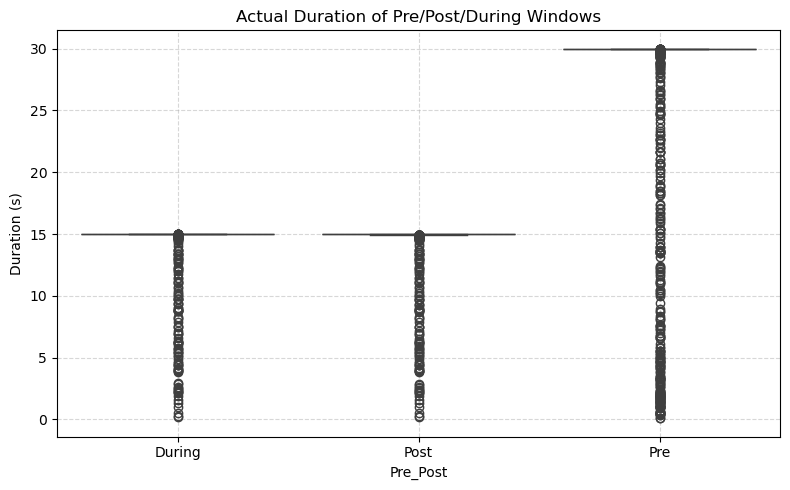

In [12]:
# sanity check 1: Actual window sizes
duration_df = filtered_trials_long_df.groupby(['Trial_ID', 'Pre_Post'])['timeStampDataPointEnd'].agg(['min', 'max']).reset_index()
duration_df['Duration_s'] = duration_df['max'] - duration_df['min']

plt.figure(figsize=(8, 5))
sns.boxplot(data=duration_df, x='Pre_Post', y='Duration_s')
plt.title("Actual Duration of Pre/Post/During Windows")
plt.ylabel("Duration (s)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


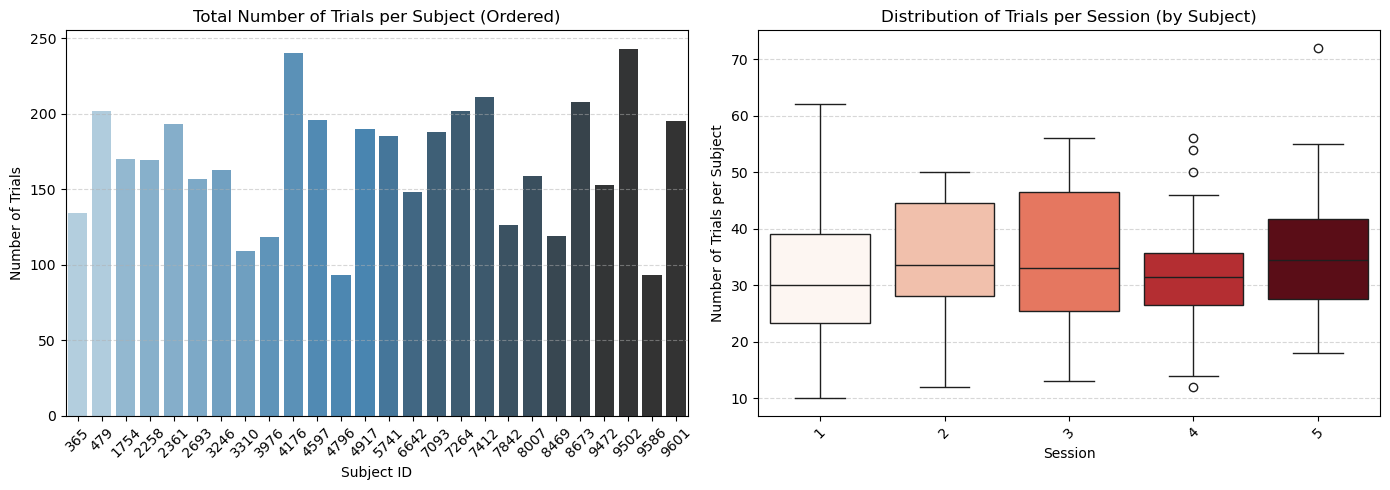

In [13]:
# --- : Count trials per subject-session ---
per_subject_session = (
    filtered_trials_long_df.groupby(['SubjectID', 'Session'])['Trial_ID']
    .nunique()
    .reset_index(name='n_windows')
)

# --- : Count total trials per subject and sort ---
trials_per_subject = (
    filtered_trials_long_df.groupby('SubjectID')['Trial_ID']
    .nunique()
    .reset_index(name='n_windows')
    .sort_values('n_windows')  # sort by ascending trial count
)

# Extract sorted subject order
subject_order = filtered_trials_long_df["SubjectID"].tolist()

# --- : Plotting ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=False)

# --- Left plot: Barplot per subject (ordered, warning-free) ---
sns.barplot(
    data=trials_per_subject,
    x='SubjectID',
    y='n_windows',
    hue='SubjectID',         # fix future warning
    palette='Blues_d',
    legend=False,
    order=subject_order,     # enforce order
    ax=axes[0]
)
axes[0].set_title("Total Number of Trials per Subject (Ordered)")
axes[0].set_ylabel("Number of Trials")
axes[0].set_xlabel("Subject ID")
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', linestyle='--', alpha=0.5)

# --- Right plot: Boxplot per session (warning-free) ---
sns.boxplot(
    data=per_subject_session,
    x='Session',
    y='n_windows',
    hue='Session',
    palette='Reds',
    legend=False,
    ax=axes[1]
)
axes[1].set_title("Distribution of Trials per Session (by Subject)")
axes[1].set_ylabel("Number of Trials per Subject")
axes[1].set_xlabel("Session")
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [14]:
# --- : Count trials per Subject Ã— Session (for heatmap) ---
trials_per_subject_session = (
    filtered_trials_long_df.groupby(['SubjectID', 'Session'])['Trial_ID']
    .nunique()
    .reset_index(name='n_trials')
)

# Pivot table for heatmap
heatmap_data = trials_per_subject_session.pivot(
    index='SubjectID',
    columns='Session',
    values='n_trials'
).fillna(0)

In [15]:
heatmap_data

Session     1   2   3   4   5
SubjectID                    
365        30  17  32  26  29
479        36  45  48  30  43
1754       39  28  32  32  39
2258       42  37  25  34  31
2361       10  34  53  54  42
2693       36  45  25  26  25
3246       27  48  56  14  18
3310       12  28  22  20  27
3976       18  47  16  12  25
4176       33  47  55  50  55
4597       41  40  40  34  41
4796       15  12  27  17  22
4917       47  36  30  39  38
5741       30  43  43  30  39
6642       30  22  34  36  26
7093       45  35  41  34  33
7264       27  33  48  41  53
7412       25  31  27  56  72
7842       24  21  20  30  31
8007       35  16  41  31  36
8469       17  30  13  28  31
8673       40  50  45  29  44
9472       23  31  31  35  33
9502       62  48  49  46  38
9586       22  17  17  16  21
9601       39  32  47  35  42

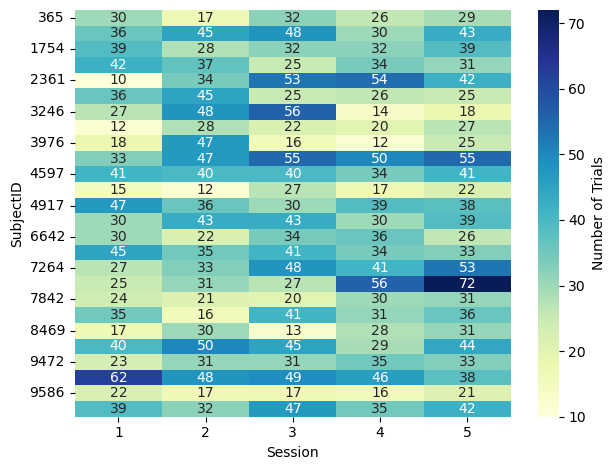

In [16]:
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".0f",
    cmap='YlGnBu',
    cbar_kws={'label': 'Number of Trials'}
)


plt.tight_layout()
plt.show()

In [17]:
trials_per_subject

SubjectID  n_windows
11       4796         93
24       9586         93
7        3310        109
8        3976        118
20       8469        119
18       7842        126
0         365        134
14       6642        148
22       9472        153
5        2693        157
19       8007        159
6        3246        163
3        2258        169
2        1754        170
13       5741        185
15       7093        188
12       4917        190
4        2361        193
25       9601        195
10       4597        196
1         479        202
16       7264        202
21       8673        208
17       7412        211
9        4176        240
23       9502        243

/var/folders/wj/11sgsjxd7x75l9tkc6r2l1p80000gn/T/ipykernel_1142/7870021.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


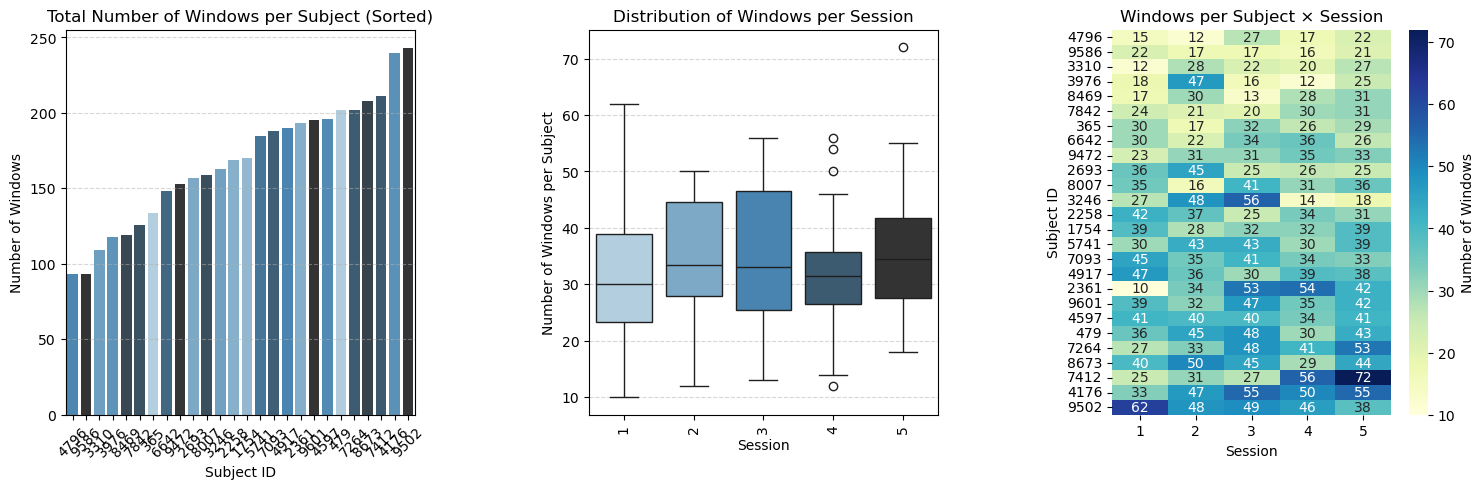

In [18]:
# --- Sort subject order by number of trials ---
subject_order = trials_per_subject.sort_values('n_windows')['SubjectID'].tolist()

# --- Reorder heatmap index ---
heatmap_data_ordered = heatmap_data.loc[subject_order]

# --- : Plotting all three ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5), gridspec_kw={'wspace': 0.5})

# --- Plot 1: Barplot per Subject (sorted ascending) ---
sns.barplot(
    data=trials_per_subject,
    x='SubjectID',
    y='n_windows',
    hue='SubjectID',
    palette='Blues_d',
    legend=False,
    order=subject_order,
    ax=axes[0]
)
axes[0].set_title("Total Number of Windows per Subject (Sorted)")
axes[0].set_ylabel("Number of Windows")
axes[0].set_xlabel("Subject ID")
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', linestyle='--', alpha=0.5)

# --- Plot 2: Boxplot per Session ---
sns.boxplot(
    data=per_subject_session,
    x='Session',
    y='n_windows',
    hue='Session',
    palette='Blues_d',
    legend=False,
    ax=axes[1]
)
axes[1].set_title("Distribution of Windows per Session")
axes[1].set_ylabel("Number of Windows per Subject")
axes[1].set_xlabel("Session")
axes[1].tick_params(axis='x', rotation=90)
axes[1].grid(axis='y', linestyle='--', alpha=0.5)

# --- Plot 3: Heatmap Subject Ã— Session (with subject order) ---
sns.heatmap(
    heatmap_data_ordered,
    annot=True,
    fmt=".0f",
    cmap='YlGnBu',
    cbar_kws={'label': 'Number of Windows'},
    ax=axes[2]
)
axes[2].set_title("Windows per Subject Ã— Session")
axes[2].set_xlabel("Session")
axes[2].set_ylabel("Subject ID")

# --- Save the figure ---
plt.tight_layout()
plt.savefig("window_summary.png", dpi=300, bbox_inches='tight')  # High-res save
plt.show()


In [19]:
# Create a copy of the original column with updated labels
filtered_trials_long_df["Pre_Post_Collapsed"] = filtered_trials_long_df["Pre_Post"].replace({"During": "Post"})


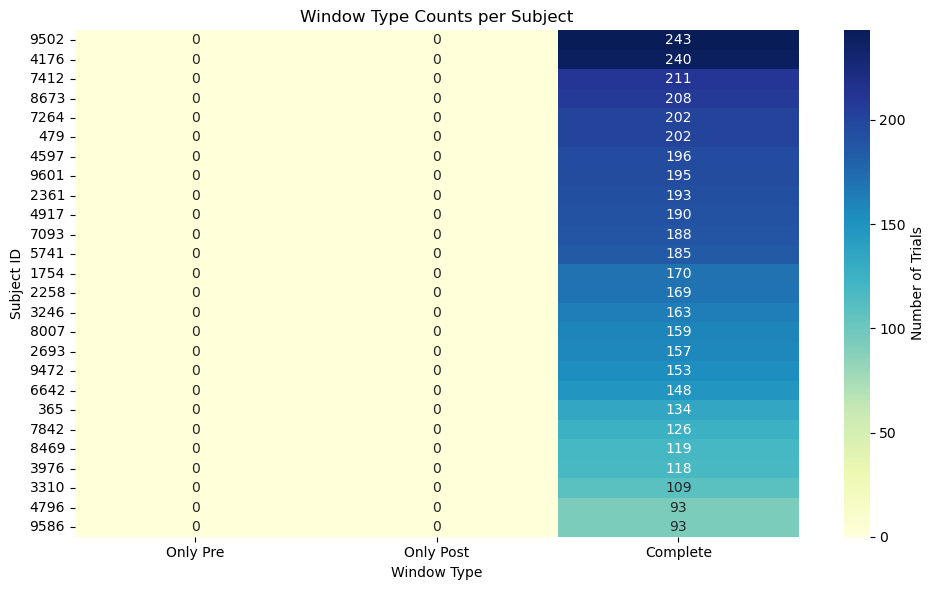

In [20]:
# : Get window presence per SubjectID Ã— Trial_ID
window_presence = (
    filtered_trials_long_df
    .groupby(['SubjectID', 'Trial_ID'])['Pre_Post_Collapsed']
    .unique()
    .reset_index()
)

# : Classify window status
def classify_window(labels):
    label_set = set(labels)
    if 'Pre' in label_set and 'Post' in label_set:
        return 'Complete'
    elif 'Pre' in label_set:
        return 'Only Pre'
    elif 'Post' in label_set:
        return 'Only Post'
    else:
        return 'Other'

window_presence['Window_Status'] = window_presence['Pre_Post_Collapsed'].apply(classify_window)

# : Count window statuses per SubjectID
status_counts = (
    window_presence
    .groupby(['SubjectID', 'Window_Status'])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

# Optional: Fill missing categories with 0 if they donâ€™t exist for some subjects
for col in ['Complete', 'Only Pre', 'Only Post', 'Other']:
    if col not in status_counts.columns:
        status_counts[col] = 0

# : (Optional) visualize as heatmap
import seaborn as sns
import matplotlib.pyplot as plt

# Sort subjects by total trials (optional)
status_counts['Total'] = status_counts[['Complete', 'Only Pre', 'Only Post']].sum(axis=1)
status_counts = status_counts.sort_values('Total', ascending=False)

# Set SubjectID as index
heatmap_data = status_counts.set_index('SubjectID')[['Only Pre', 'Only Post', 'Complete']]

# Plot
plt.figure(figsize=(10, 6))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt='d',
    cmap='YlGnBu',
    cbar_kws={'label': 'Number of Trials'}
)
plt.title('Window Type Counts per Subject')
plt.xlabel('Window Type')
plt.ylabel('Subject ID')
plt.tight_layout()
plt.show()


In [21]:
filtered_trials_long_df[[ 'SubjectID', 'events', "Pre_Post_Collapsed", 'Trial_ID']].value_counts()

SubjectID  events  Pre_Post_Collapsed  Trial_ID               
3246        2.0    Post                28_Cma_3246_2_1_Trial_1    157
           -2.0    Post                28_Cma_3246_2_1_Trial_1    156
            1.0    Post                28_Cma_3246_2_1_Trial_1    156
           -1.0    Post                28_Cma_3246_2_1_Trial_1    156
479         2.0    Post                37_Sa_479_3_2_Trial_1      149
                                                                 ... 
7842        2.0    Pre                 46_Sa_7842_1_1_Trial_1       1
2693        2.0    Post                55_Sa_2693_1_1_Trial_1       1
7842       -2.0    Pre                 46_Sa_7842_1_1_Trial_1       1
4917        2.0    Post                09_Cma_4917_5_2_Trial_1      1
7842        1.0    Pre                 46_Sa_7842_1_1_Trial_1       1
Name: count, Length: 34897, dtype: int64

In [22]:
filtered_trials_long_df.head()

SubjectID  Session  SessionSubsection  timeStampDataPointEnd  \
0        365        1                  1           1.635519e+09   
1        365        1                  1           1.635519e+09   
2        365        1                  1           1.635519e+09   
3        365        1                  1           1.635519e+09   
4        365        1                  1           1.635519e+09   

   eyeOpennessLeft  eyeOpennessRight  pupilDiameterMillimetersLeft  \
0              1.0               1.0                      3.333588   
1              1.0               1.0                      3.291748   
2              1.0               1.0                      3.291748   
3              1.0               1.0                      3.259613   
4              1.0               1.0                      3.259613   

   pupilDiameterMillimetersRight  leftGazeValidityBitmask  \
0                       3.785751                       31   
1                       3.744843                       31   
2                       3.744843                       31   
3                       3.707169                       31   
4                       3.707169                       31   

   rightGazeValidityBitmask  ...         names Collider_CategoricalN  \
0                        31  ...  Building_161              Building   
1                        31  ...  Building_161              Building   
2                        31  ...  Building_161              Building   
3                        31  ...  Building_161              Building   
4                        31  ...  Building_161              Building   

  was_inserted                   date_seconds  Pre_Post  \
0        False  2021-10-29 14:55:46.468227625       Pre   
1        False  2021-10-29 14:55:46.476162910       Pre   
2        False  2021-10-29 14:55:46.484594345       Pre   
3        False  2021-10-29 14:55:46.493522644       Pre   
4        False  2021-10-29 14:55:46.504436016       Pre   

                Trial_ID  Collider_Name  Occurrence_Order  \
0  46_Sa_365_1_1_Trial_1          46_Sa                 1   
1  46_Sa_365_1_1_Trial_1          46_Sa                 1   
2  46_Sa_365_1_1_Trial_1          46_Sa                 1   
3  46_Sa_365_1_1_Trial_1          46_Sa                 1   
4  46_Sa_365_1_1_Trial_1          46_Sa                 1   

                      Event_Time  Pre_Post_Collapsed  
0  2021-10-29 14:56:01.897292376                 Pre  
1  2021-10-29 14:56:01.897292376                 Pre  
2  2021-10-29 14:56:01.897292376                 Pre  
3  2021-10-29 14:56:01.897292376                 Pre  
4  2021-10-29 14:56:01.897292376                 Pre  

[5 rows x 95 columns]

In [23]:
filtered_trials_long_df.head()

SubjectID  Session  SessionSubsection  timeStampDataPointEnd  \
0        365        1                  1           1.635519e+09   
1        365        1                  1           1.635519e+09   
2        365        1                  1           1.635519e+09   
3        365        1                  1           1.635519e+09   
4        365        1                  1           1.635519e+09   

   eyeOpennessLeft  eyeOpennessRight  pupilDiameterMillimetersLeft  \
0              1.0               1.0                      3.333588   
1              1.0               1.0                      3.291748   
2              1.0               1.0                      3.291748   
3              1.0               1.0                      3.259613   
4              1.0               1.0                      3.259613   

   pupilDiameterMillimetersRight  leftGazeValidityBitmask  \
0                       3.785751                       31   
1                       3.744843                       31   
2                       3.744843                       31   
3                       3.707169                       31   
4                       3.707169                       31   

   rightGazeValidityBitmask  ...         names Collider_CategoricalN  \
0                        31  ...  Building_161              Building   
1                        31  ...  Building_161              Building   
2                        31  ...  Building_161              Building   
3                        31  ...  Building_161              Building   
4                        31  ...  Building_161              Building   

  was_inserted                   date_seconds  Pre_Post  \
0        False  2021-10-29 14:55:46.468227625       Pre   
1        False  2021-10-29 14:55:46.476162910       Pre   
2        False  2021-10-29 14:55:46.484594345       Pre   
3        False  2021-10-29 14:55:46.493522644       Pre   
4        False  2021-10-29 14:55:46.504436016       Pre   

                Trial_ID  Collider_Name  Occurrence_Order  \
0  46_Sa_365_1_1_Trial_1          46_Sa                 1   
1  46_Sa_365_1_1_Trial_1          46_Sa                 1   
2  46_Sa_365_1_1_Trial_1          46_Sa                 1   
3  46_Sa_365_1_1_Trial_1          46_Sa                 1   
4  46_Sa_365_1_1_Trial_1          46_Sa                 1   

                      Event_Time  Pre_Post_Collapsed  
0  2021-10-29 14:56:01.897292376                 Pre  
1  2021-10-29 14:56:01.897292376                 Pre  
2  2021-10-29 14:56:01.897292376                 Pre  
3  2021-10-29 14:56:01.897292376                 Pre  
4  2021-10-29 14:56:01.897292376                 Pre  

[5 rows x 95 columns]

In [24]:
# Ensure Event_Time is in datetime format
filtered_trials_long_df['Event_Time'] = pd.to_datetime(filtered_trials_long_df['Event_Time'])

# Keep only agent encounter events (event == 2)
encounter_events = filtered_trials_long_df[filtered_trials_long_df['events'] == 2].copy()

# Remove duplicates to retain one entry per unique agent encounter
event_onsets = (
    encounter_events
    .drop_duplicates(subset=['SubjectID', 'Session', 'SessionSubsection',  'Event_Time'])
    .sort_values(['SubjectID', 'Session', 'SessionSubsection',  'Event_Time'])
    .copy()
)

# Compute time since last fixation on the same agent
event_onsets['time_since_last_event'] = (
    event_onsets
    .groupby(['SubjectID', 'Session', 'SessionSubsection'])['Event_Time']
    .diff()
    .dt.total_seconds()
)

# Flag events that occurred less than 30 seconds after the previous one
event_onsets['too_close'] = event_onsets['time_since_last_event'] < 30

# View rows that violate the 30-second spacing rule
violations = event_onsets[event_onsets['too_close']][
    ['SubjectID', 'Session', 'SessionSubsection',  'Event_Time', 'time_since_last_event']
]

display(violations)


SubjectID  Session  SessionSubsection                    Event_Time  \
2890            365        1                  1 2021-10-29 14:56:29.729325294   
6590            365        1                  1 2021-10-29 14:56:40.368519306   
21614           365        1                  1 2021-10-29 14:59:34.242718220   
25362           365        1                  1 2021-10-29 14:59:52.313477516   
36775           365        1                  1 2021-10-29 15:01:40.282206774   
...             ...      ...                ...                           ...   
18480301       9601        5                  3 2022-05-17 14:25:57.448004246   
18495882       9601        5                  3 2022-05-17 14:31:41.340177536   
18499637       9601        5                  3 2022-05-17 14:31:49.936353445   
18507136       9601        5                  3 2022-05-17 14:32:35.318369150   
18510927       9601        5                  3 2022-05-17 14:32:47.060176373   

          time_since_last_event  
2890                  27.832033  
6590                  10.639194  
21614                 12.480345  
25362                 18.070759  
36775                 15.437992  
...                         ...  
18480301              22.640416  
18495882              19.757664  
18499637               8.596176  
18507136              14.497088  
18510927              11.741807  

[1645 rows x 5 columns]

In [25]:
# Sort events by time across all agents
event_onsets_sorted = (
    event_onsets
    .sort_values(['SubjectID', 'Session', 'SessionSubsection', 'Event_Time'])
    .copy()
)

# Calculate time differences between *all* consecutive windows
event_onsets_sorted['inter_window_gap'] = (
    event_onsets_sorted
    .groupby(['SubjectID', 'Session', 'SessionSubsection'])['Event_Time']
    .diff()
    .dt.total_seconds()
)

# Ensure correct column is used
gap_col = 'time_since_last_event'

# Filter outliers using 99th percentile
threshold = event_onsets[gap_col].quantile(0.99)
gap_filtered = event_onsets[event_onsets[gap_col] < threshold]


In [26]:
# Prepare the data
data = gap_filtered['time_since_last_event'].dropna()
kde = gaussian_kde(data)

# Integration bounds
x_min = data.min()
x_max = data.max()
threshold = 30

# Integrate KDE from 0 to 30
area_before, _ = quad(kde, x_min, threshold)
area_after, _ = quad(kde, threshold, x_max)
total_area = area_before + area_after

# Normalize
prop_before = area_before / total_area
prop_after = area_after / total_area

print(f"Proportion of KDE area before 30s: {prop_before:.2%}")
print(f"Proportion of KDE area after 30s:  {prop_after:.2%}")


Proportion of KDE area before 30s: 40.51%
Proportion of KDE area after 30s:  59.49%


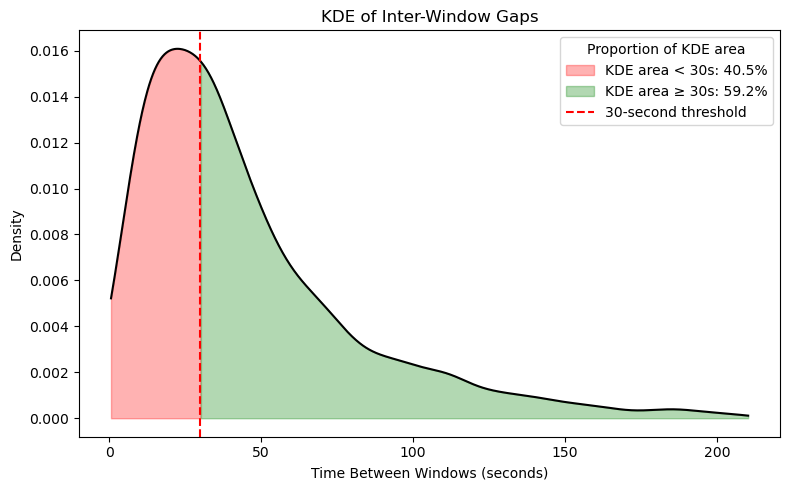

In [27]:
# Your data
data = gap_filtered['time_since_last_event'].dropna()
threshold = 30

# KDE
kde = gaussian_kde(data)
x_vals = np.linspace(data.min(), data.max(), 1000)
y_vals = kde(x_vals)

# Compute KDE areas
area_total = np.trapz(y_vals, x_vals)
area_before = np.trapz(y_vals[x_vals <= threshold], x_vals[x_vals <= threshold])
area_after = np.trapz(y_vals[x_vals > threshold], x_vals[x_vals > threshold])

prop_before = 100 * area_before / area_total
prop_after = 100 * area_after / area_total

# Plot
plt.figure(figsize=(8, 5))
plt.plot(x_vals, y_vals, color='black')

# Shade area before and after 30s
plt.fill_between(x_vals, y_vals, where=(x_vals <= threshold), alpha=0.3, color='red',
                 label=f'KDE area < 30s: {prop_before:.1f}%')
plt.fill_between(x_vals, y_vals, where=(x_vals > threshold), alpha=0.3, color='green',
                 label=f'KDE area â‰¥ 30s: {prop_after:.1f}%')

# Add 30s reference line
plt.axvline(threshold, color='red', linestyle='--', label='30-second threshold')

plt.title('KDE of Inter-Window Gaps')
plt.xlabel('Time Between Windows (seconds)')
plt.ylabel('Density')
plt.legend(title="Proportion of KDE area")
plt.tight_layout()
plt.show()


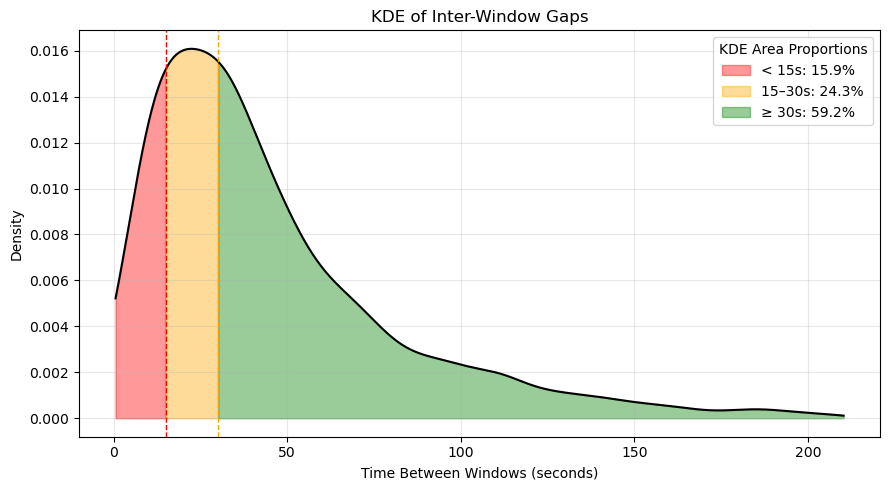

In [28]:


# Thresholds
threshold_15 = 15
threshold_30 = 30

# KDE
kde = gaussian_kde(data)
x_vals = np.linspace(data.min(), data.max(), 1000)
y_vals = kde(x_vals)

# Compute KDE areas
area_total = np.trapz(y_vals, x_vals)

# Define masks
mask_lt_15 = x_vals <= threshold_15
mask_15_30 = (x_vals > threshold_15) & (x_vals <= threshold_30)
mask_gt_30 = x_vals > threshold_30

# Compute areas
area_lt_15 = np.trapz(y_vals[mask_lt_15], x_vals[mask_lt_15])
area_15_30 = np.trapz(y_vals[mask_15_30], x_vals[mask_15_30])
area_gt_30 = np.trapz(y_vals[mask_gt_30], x_vals[mask_gt_30])

# Compute proportions
prop_lt_15 = 100 * area_lt_15 / area_total
prop_15_30 = 100 * area_15_30 / area_total
prop_gt_30 = 100 * area_gt_30 / area_total

# Plot
plt.figure(figsize=(9, 5))
plt.plot(x_vals, y_vals, color='black')

# Fill shaded areas
plt.fill_between(x_vals, y_vals, where=mask_lt_15, color='red', alpha=0.4,
                 label=f'< 15s: {prop_lt_15:.1f}%')
plt.fill_between(x_vals, y_vals, where=mask_15_30, color='orange', alpha=0.4,
                 label=f'15â€“30s: {prop_15_30:.1f}%')
plt.fill_between(x_vals, y_vals, where=mask_gt_30, color='green', alpha=0.4,
                 label=f'â‰¥ 30s: {prop_gt_30:.1f}%')

# Threshold lines
plt.axvline(threshold_15, color='red', linestyle='--', linewidth=1)
plt.axvline(threshold_30, color='orange', linestyle='--', linewidth=1)

plt.title('KDE of Inter-Window Gaps')
plt.xlabel('Time Between Windows (seconds)')
plt.ylabel('Density')
plt.legend(title="KDE Area Proportions")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [29]:
event_onsets['time_since_last_event'].describe()

count     3992.000000
mean        70.058076
std       1409.531816
min          0.588751
25%         19.371146
50%         34.941198
75%         60.523161
max      89051.485500
Name: time_since_last_event, dtype: float64

In [30]:
encounter_events.Pre_Post_Collapsed.value_counts()

Pre_Post_Collapsed
Post    419062
Pre     405895
Name: count, dtype: int64

In [31]:
# Filter out negative values first
df_valid = filtered_trials_long_df[
    (filtered_trials_long_df['pupilDiameterMillimetersRight'] >= 0) &
    (filtered_trials_long_df['pupilDiameterMillimetersLeft'] >= 0)
]

# List to hold all summaries
summary_data = []

# Group by Subject, Pre_Post, and optionally Session/Subsection if needed
grouped = df_valid.groupby(['SubjectID', 'Pre_Post_Collapsed'])

for (subject, Pre_Post_Collapsed), df_subj in grouped:
    # Right eye
    q1_r = np.nanquantile(df_subj.pupilDiameterMillimetersRight, 0.25)
    med_r = np.nanmedian(df_subj.pupilDiameterMillimetersRight)
    q3_r = np.nanquantile(df_subj.pupilDiameterMillimetersRight, 0.75)
    iqr_r = q3_r - q1_r
    bowley_r = (q3_r + q1_r - 2 * med_r) / iqr_r if iqr_r != 0 else np.nan
    mean_r = np.nanmean(df_subj.pupilDiameterMillimetersRight)
    sd_r = np.nanstd(df_subj.pupilDiameterMillimetersRight)
    max_r = np.nanmax(df_subj.pupilDiameterMillimetersRight)
    min_r = np.nanmin(df_subj.pupilDiameterMillimetersRight)

    # Left eye
    q1_l = np.nanquantile(df_subj.pupilDiameterMillimetersLeft, 0.25)
    med_l = np.nanmedian(df_subj.pupilDiameterMillimetersLeft)
    q3_l = np.nanquantile(df_subj.pupilDiameterMillimetersLeft, 0.75)
    iqr_l = q3_l - q1_l
    bowley_l = (q3_l + q1_l - 2 * med_l) / iqr_l if iqr_l != 0 else np.nan
    mean_l = np.nanmean(df_subj.pupilDiameterMillimetersLeft)
    sd_l = np.nanstd(df_subj.pupilDiameterMillimetersLeft)
    max_l = np.nanmax(df_subj.pupilDiameterMillimetersLeft)
    min_l = np.nanmin(df_subj.pupilDiameterMillimetersLeft)

    summary_data.append({
        'SubjectID': subject,
        'Pre_Post_Collapsed': Pre_Post_Collapsed,
        
        'pd_r_mm_min': min_r,
        'pd_r_mm_max': max_r,
        'pd_r_mm_mean': mean_r,
        'pd_r_mm_sd': sd_r,
        'pd_r_mm_med': med_r,
        'pd_r_mm_DistQ1-Q3': iqr_r,
        'pd_r_mm_bowleyCoef': bowley_r,

        'pd_l_mm_min': min_l,
        'pd_l_mm_max': max_l,
        'pd_l_mm_mean': mean_l,
        'pd_l_mm_sd': sd_l,
        'pd_l_mm_med': med_l,
        'pd_l_mm_DistQ1-Q3': iqr_l,
        'pd_l_mm_bowleyCoef': bowley_l
    })

# Create the summary DataFrame
df_pupilD_by_window = pd.DataFrame(summary_data)

# Optional: sort by Subject and Pre_Post order
pre_post_order = {'Pre': 0, 'Post': 1}
df_pupilD_by_window['Pre_Post_order'] = df_pupilD_by_window['Pre_Post_Collapsed'].map(pre_post_order)
df_pupilD_by_window.sort_values(['SubjectID', 'Pre_Post_order'], inplace=True)
df_pupilD_by_window.drop(columns='Pre_Post_order', inplace=True)

# Final result
df_pupilD_by_window


SubjectID Pre_Post_Collapsed  pd_r_mm_min  pd_r_mm_max  pd_r_mm_mean  \
1         365                Pre     2.029739     5.191711      3.709324   
0         365               Post     2.317627     5.206055      3.710713   
3         479                Pre     1.839371     6.694962      4.537902   
2         479               Post     2.511002     6.083603      4.564959   
5        1754                Pre     1.922623     6.029938      3.790289   
4        1754               Post     2.016220     5.626541      3.781913   
7        2258                Pre     1.279312     5.260986      3.474139   
6        2258               Post     1.611542     5.260986      3.478589   
9        2361                Pre     1.930527     5.893051      3.822403   
8        2361               Post     2.090256     5.893051      3.849825   
11       2693                Pre     1.090637     6.345108      3.126708   
10       2693               Post     1.374039     5.739304      3.148487   
13       3246                Pre     1.932419     6.164795      3.795852   
12       3246               Post     1.932419     6.108383      3.779662   
15       3310                Pre     1.378128     5.578735      3.478981   
14       3310               Post     1.515579     5.893616      3.485745   
17       3976                Pre     1.880234     5.861694      4.381735   
16       3976               Post     2.067169     6.169449      4.397104   
19       4176                Pre     1.046387     6.444946      3.849395   
18       4176               Post     1.918106     6.122986      3.852707   
21       4597                Pre     1.932449     5.458298      3.739915   
20       4597               Post     2.087631     5.458298      3.789020   
23       4796                Pre     0.881897     6.889694      3.764179   
22       4796               Post     0.881897     6.571564      3.746095   
25       4917                Pre     1.509491     6.242798      3.802382   
24       4917               Post     1.236206     6.242798      3.805196   
27       5741                Pre     1.736298     7.076965      4.102662   
26       5741               Post     1.903610     6.755524      4.115234   
29       6642                Pre     2.415634     5.742432      4.029369   
28       6642               Post     2.449142     5.581192      4.053748   
31       7093                Pre     1.995773     5.711502      3.718790   
30       7093               Post     2.440384     5.409790      3.732560   
33       7264                Pre     2.723053     6.102249      4.610102   
32       7264               Post     2.519699     6.102249      4.601685   
35       7412                Pre     2.083588     5.381058      3.526567   
34       7412               Post     2.230804     5.273315      3.542760   
37       7842                Pre     1.430298     6.630203      3.816624   
36       7842               Post     1.669281     6.951233      3.796194   
39       8007                Pre     2.812897     6.410568      4.218812   
38       8007               Post     3.045670     6.740189      4.257416   
41       8469                Pre     1.640472     4.950027      3.333720   
40       8469               Post     1.663239     4.927490      3.315730   
43       8673                Pre     1.228455     5.079407      3.375496   
42       8673               Post     1.905823     5.079407      3.387887   
45       9472                Pre     1.708618     4.693710      3.077145   
44       9472               Post     1.708618     5.182953      3.062105   
47       9502                Pre     1.439133     5.025558      3.404794   
46       9502               Post     1.538712     5.083649      3.435341   
49       9586                Pre     2.055542     5.652771      3.794690   
48       9586               Post     2.480774     5.508926      3.833976   
51       9601                Pre     2.526306     7.510269      4.692216   
50       9601               Post     2.481873     7.

In [32]:
df_pupilD_by_window.head()

SubjectID Pre_Post_Collapsed  pd_r_mm_min  pd_r_mm_max  pd_r_mm_mean  \
1        365                Pre     2.029739     5.191711      3.709324   
0        365               Post     2.317627     5.206055      3.710713   
3        479                Pre     1.839371     6.694962      4.537902   
2        479               Post     2.511002     6.083603      4.564959   
5       1754                Pre     1.922623     6.029938      3.790289   

   pd_r_mm_sd  pd_r_mm_med  pd_r_mm_DistQ1-Q3  pd_r_mm_bowleyCoef  \
1    0.466506     3.670441           0.683029            0.092063   
0    0.453347     3.703766           0.657784           -0.014603   
3    0.425675     4.571838           0.510666           -0.041683   
2    0.418674     4.596664           0.492653           -0.032227   
5    0.406177     3.765015           0.500458            0.018904   

   pd_l_mm_min  pd_l_mm_max  pd_l_mm_mean  pd_l_mm_sd  pd_l_mm_med  \
1     1.546005     5.258133      3.556198    0.371361     3.564163   
0     1.546005     5.027069      3.558111    0.361177     3.589569   
3     2.033173     6.607117      4.881182    0.419568     4.898682   
2     2.724640     6.560104      4.903220    0.419406     4.925354   
5     1.183945     5.466812      3.549885    0.423404     3.496231   

   pd_l_mm_DistQ1-Q3  pd_l_mm_bowleyCoef  
1           0.548084           -0.035935  
0           0.524948           -0.132343  
3           0.532028           -0.016721  
2           0.540955           -0.034356  
5           0.538422            0.085530

[Right Eye | Post] Area under KDE curve: 0.8904
[Right Eye | Pre] Area under KDE curve: 0.8893
[Left Eye | Post] Area under KDE curve: 0.8950
[Left Eye | Pre] Area under KDE curve: 0.8955


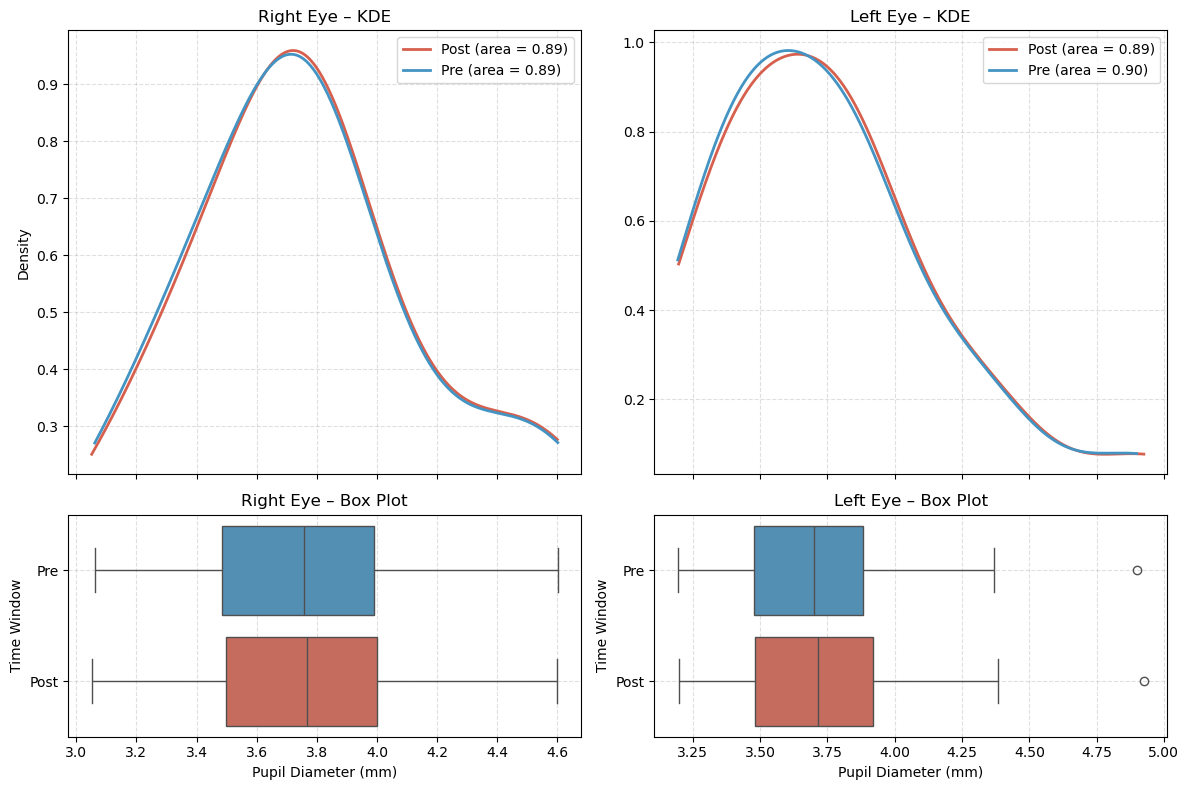

In [33]:


# --- : Melt and clean data ---
df_melted = pd.melt(
    df_pupilD_by_window,
    id_vars=['SubjectID', 'Pre_Post_Collapsed'],
    value_vars=['pd_r_mm_med', 'pd_l_mm_med'],
    var_name='Eye',
    value_name='Median_Pupil_Diameter'
)

df_melted['Eye'] = df_melted['Eye'].map({
    'pd_r_mm_med': 'Right Eye',
    'pd_l_mm_med': 'Left Eye'
})

df_melted['Eye'] = df_melted['Eye'].astype(str)
df_melted['Pre_Post_Collapsed'] = df_melted['Pre_Post_Collapsed'].astype(str)
df_melted['Median_Pupil_Diameter'] = pd.to_numeric(df_melted['Median_Pupil_Diameter'], errors='coerce')
df_melted_clean = df_melted.dropna(subset=["Median_Pupil_Diameter"])

# --- : Setup plot layout ---
fig, axes = plt.subplots(2, 2, figsize=(12, 8), gridspec_kw={'height_ratios': [2, 1]}, sharex='col')

# --- : Define redâ€“blue palette ---

full_palette = sns.color_palette("RdBu", n_colors=4)
unique_groups = sorted(df_melted_clean["Pre_Post_Collapsed"].unique())

# Assign first and last colors (deep blue and deep red)
group_colors = {
    unique_groups[0]: full_palette[0],   # Deep blue
    unique_groups[-1]: full_palette[-1]  # Deep red
}

# --- : Top row â€“ KDEs with area under curve ---
for i, eye in enumerate(["Right Eye", "Left Eye"]):
    ax = axes[0, i]
    eye_data = df_melted_clean[df_melted_clean["Eye"] == eye]

    for group in unique_groups:
        subset = eye_data[eye_data["Pre_Post_Collapsed"] == group]["Median_Pupil_Diameter"].dropna()
        if len(subset) < 2:
            continue

        kde = gaussian_kde(subset)

        std = subset.std()
        x_min = subset.min()
        x_max = subset.max()
        x_vals = np.linspace(x_min, x_max, 500)
        y_vals = kde(x_vals)

        area = np.trapz(y_vals, x_vals)
        print(f"[{eye} | {group}] Area under KDE curve: {area:.4f}")

        ax.plot(x_vals, y_vals, lw=2, label=f"{group} (area = {area:.2f})", color=group_colors[group])

    ax.set_title(f"{eye} â€“ KDE")
    ax.set_xlabel("")
    ax.set_ylabel("Density" if i == 0 else "")
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.4)

# --- : Bottom row â€“ Horizontal boxplots ---
for i, eye in enumerate(["Right Eye", "Left Eye"]):
    ax = axes[1, i]
    eye_data = df_melted_clean[df_melted_clean["Eye"] == eye]

    sns.boxplot(
        data=eye_data,
        y="Pre_Post_Collapsed",
        x="Median_Pupil_Diameter",
        orient="h",
        hue="Pre_Post_Collapsed",
        palette=group_colors,
        dodge=False,
        legend=False,
        ax=ax
    )
    ax.set_title(f"{eye} â€“ Box Plot")
    ax.set_xlabel("Pupil Diameter (mm)")
    ax.set_ylabel("Time Window")
    ax.grid(True, linestyle='--', alpha=0.4)

# --- : Layout adjustment ---
plt.tight_layout()
plt.show()


In [34]:
df_pupilD_by_window.to_csv("/Volumes/TwoTeras/PCA/Data_Sets/Experiment_1/df_pupilD_by_window.csv", index=False)

In [35]:
gap_filtered.Pre_Post.value_counts()

Pre_Post
Pre    3952
Name: count, dtype: int64

In [36]:
filtered_trials_long_df.head()

SubjectID  Session  SessionSubsection  timeStampDataPointEnd  \
0        365        1                  1           1.635519e+09   
1        365        1                  1           1.635519e+09   
2        365        1                  1           1.635519e+09   
3        365        1                  1           1.635519e+09   
4        365        1                  1           1.635519e+09   

   eyeOpennessLeft  eyeOpennessRight  pupilDiameterMillimetersLeft  \
0              1.0               1.0                      3.333588   
1              1.0               1.0                      3.291748   
2              1.0               1.0                      3.291748   
3              1.0               1.0                      3.259613   
4              1.0               1.0                      3.259613   

   pupilDiameterMillimetersRight  leftGazeValidityBitmask  \
0                       3.785751                       31   
1                       3.744843                       31   
2                       3.744843                       31   
3                       3.707169                       31   
4                       3.707169                       31   

   rightGazeValidityBitmask  ...         names Collider_CategoricalN  \
0                        31  ...  Building_161              Building   
1                        31  ...  Building_161              Building   
2                        31  ...  Building_161              Building   
3                        31  ...  Building_161              Building   
4                        31  ...  Building_161              Building   

  was_inserted                   date_seconds  Pre_Post  \
0        False  2021-10-29 14:55:46.468227625       Pre   
1        False  2021-10-29 14:55:46.476162910       Pre   
2        False  2021-10-29 14:55:46.484594345       Pre   
3        False  2021-10-29 14:55:46.493522644       Pre   
4        False  2021-10-29 14:55:46.504436016       Pre   

                Trial_ID  Collider_Name  Occurrence_Order  \
0  46_Sa_365_1_1_Trial_1          46_Sa                 1   
1  46_Sa_365_1_1_Trial_1          46_Sa                 1   
2  46_Sa_365_1_1_Trial_1          46_Sa                 1   
3  46_Sa_365_1_1_Trial_1          46_Sa                 1   
4  46_Sa_365_1_1_Trial_1          46_Sa                 1   

                     Event_Time  Pre_Post_Collapsed  
0 2021-10-29 14:56:01.897292376                 Pre  
1 2021-10-29 14:56:01.897292376                 Pre  
2 2021-10-29 14:56:01.897292376                 Pre  
3 2021-10-29 14:56:01.897292376                 Pre  
4 2021-10-29 14:56:01.897292376                 Pre  

[5 rows x 95 columns]

In [37]:
# : Filter fixations (as before)
fixations = filtered_trials_long_df[filtered_trials_long_df.events == 2]

# : Count number of fixations per subject Ã— condition
n_fix_df = (
    fixations
    .groupby(['SubjectID', 'Pre_Post_Collapsed'])
    .size()
    .reset_index(name='NFix')
    .astype({'SubjectID': str})
)

# : Count number of unique trials per subject Ã— condition
n_trials_df = (
    fixations
    .groupby(['SubjectID', 'Pre_Post_Collapsed'])['Trial_ID']
    .nunique()
    .reset_index(name='NTrials')
    .astype({'SubjectID': str})
)

# : Merge and normalize
n_fix_df = pd.merge(n_fix_df, n_trials_df, on=['SubjectID', 'Pre_Post_Collapsed'])
n_fix_df['Fixations_per_Trial'] = n_fix_df['NFix'] / n_fix_df['NTrials']


In [38]:
fixations.Pre_Post_Collapsed.value_counts()

Pre_Post_Collapsed
Post    419062
Pre     405895
Name: count, dtype: int64

In [39]:
n_fix_df.head()

SubjectID Pre_Post_Collapsed   NFix  NTrials  Fixations_per_Trial
0       365               Post  12916      134            96.388060
1       365                Pre  12538      134            93.567164
2       479               Post  19894      202            98.485149
3       479                Pre  18862      201            93.840796
4      1754               Post  16988      170            99.929412

[Post] Area under KDE curve: 0.9375
[Pre] Area under KDE curve: 0.9374


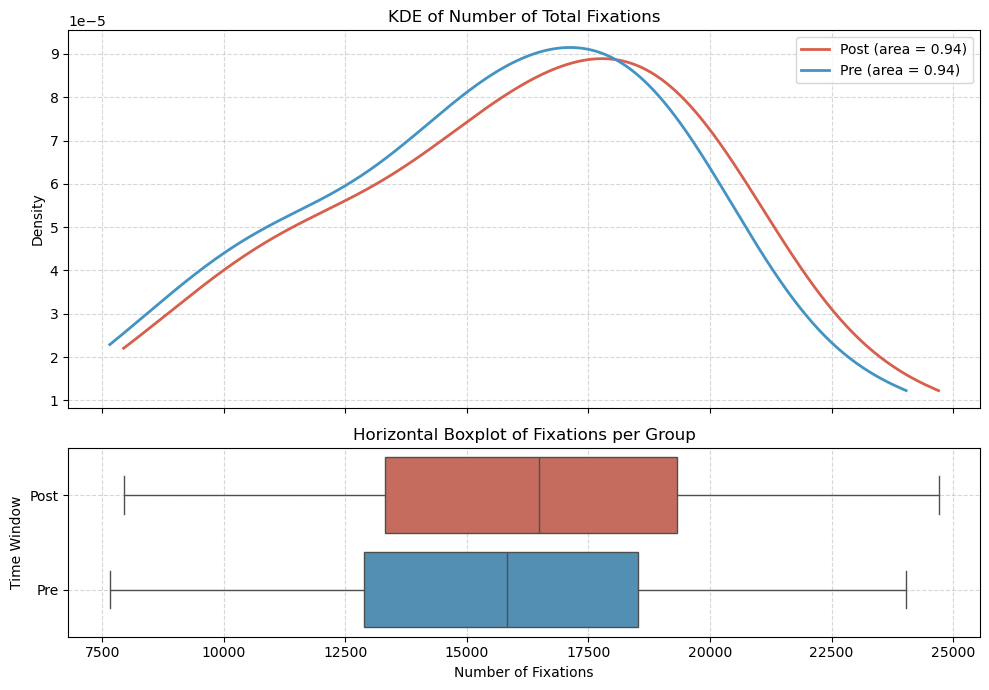

In [40]:
# --- : Clean data ---
df_clean = n_fix_df.dropna(subset=["NFix", "Pre_Post_Collapsed"])

# --- : Setup layout ---
fig, axes = plt.subplots(2, 1, figsize=(10, 7), gridspec_kw={'height_ratios': [2, 1]}, sharex=True)

# --- : KDEs (tight edges) ---
ax_kde = axes[0]
unique_groups = sorted(df_clean['Pre_Post_Collapsed'].unique())

for group in unique_groups:
    subset = df_clean[df_clean['Pre_Post_Collapsed'] == group]['NFix'].dropna()
    if len(subset) < 2:
        continue  # skip if not enough data

    # KDE
    kde = gaussian_kde(subset)

    # Tight range: just observed min/max
    x_vals = np.linspace(subset.min(), subset.max(), 500)
    y_vals = kde(x_vals)

    # Area under KDE curve
    area = np.trapz(y_vals, x_vals)
    print(f"[{group}] Area under KDE curve: {area:.4f}")

    ax_kde.plot(x_vals, y_vals, lw=2, label=f"{group} (area = {area:.2f})", color=group_colors[group])

ax_kde.set_title("KDE of Number of Total Fixations")
ax_kde.set_ylabel("Density")
ax_kde.legend()
ax_kde.grid(True, linestyle='--', alpha=0.5)

# --- : Horizontal boxplot ---
ax_box = axes[1]
sns.boxplot(
    data=df_clean,
    y="Pre_Post_Collapsed",
    x="NFix",
    orient="h",
    hue="Pre_Post_Collapsed",
    palette=group_colors,
    dodge=False,
    legend=False,
    ax=ax_box
)
ax_box.set_title("Horizontal Boxplot of Fixations per Group")
ax_box.set_xlabel("Number of Fixations")
ax_box.set_ylabel("Time Window")
ax_box.grid(True, linestyle='--', alpha=0.5)

# --- : Final layout ---
plt.tight_layout()
plt.show()


In [41]:
df_clean[df_clean['Pre_Post_Collapsed'] == group]['Fixations_per_Trial'].shape

(26,)

[Post] Area under KDE curve: 0.9446
[Pre] Area under KDE curve: 0.9280


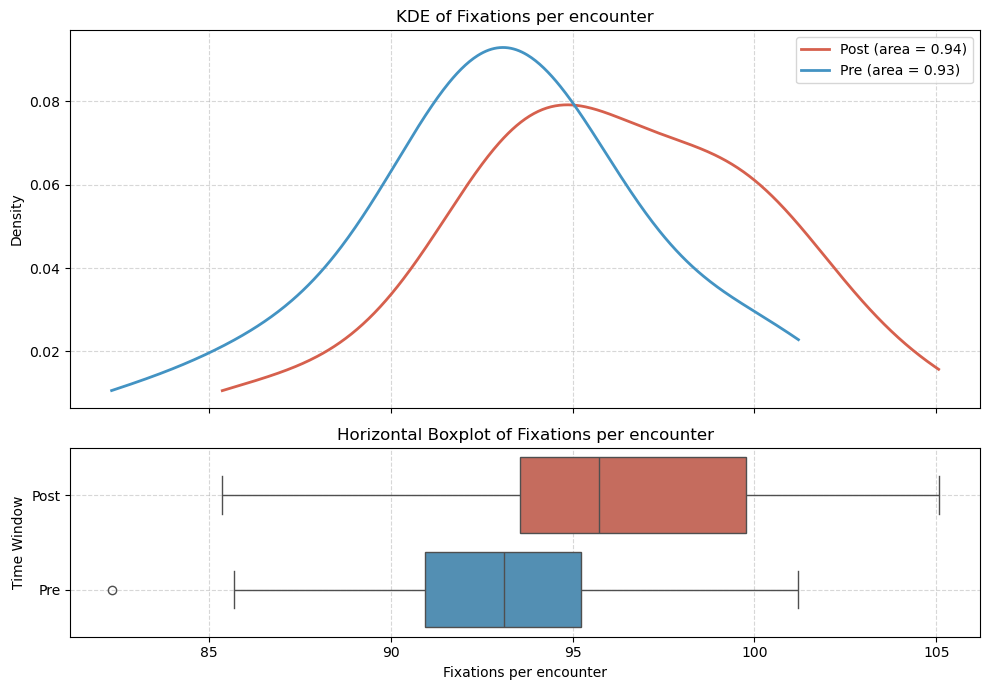

In [42]:
# --- : Clean data ---
df_clean = n_fix_df.dropna(subset=["Fixations_per_Trial", "Pre_Post_Collapsed"])

# --- : Setup layout ---
fig, axes = plt.subplots(2, 1, figsize=(10, 7), gridspec_kw={'height_ratios': [2, 1]}, sharex=True)

# --- : KDEs (tight edges) ---
ax_kde = axes[0]
unique_groups = sorted(df_clean['Pre_Post_Collapsed'].unique())

for group in unique_groups:
    subset = df_clean[df_clean['Pre_Post_Collapsed'] == group]['Fixations_per_Trial'].dropna()
    if len(subset) < 2:
        continue  # skip if not enough data

    kde = gaussian_kde(subset)
    x_vals = np.linspace(subset.min(), subset.max(), 500)
    y_vals = kde(x_vals)

    area = np.trapz(y_vals, x_vals)
    print(f"[{group}] Area under KDE curve: {area:.4f}")

    ax_kde.plot(x_vals, y_vals, lw=2, label=f"{group} (area = {area:.2f})", color=group_colors[group])

ax_kde.set_title("KDE of Fixations per encounter")
ax_kde.set_ylabel("Density")
ax_kde.legend()
ax_kde.grid(True, linestyle='--', alpha=0.5)

# --- : Horizontal boxplot ---
ax_box = axes[1]
sns.boxplot(
    data=df_clean,
    y="Pre_Post_Collapsed",
    x="Fixations_per_Trial",
    orient="h",
    hue="Pre_Post_Collapsed",
    palette=group_colors,
    dodge=False,
    legend=False,
    ax=ax_box
)
ax_box.set_title("Horizontal Boxplot of Fixations per encounter")
ax_box.set_xlabel("Fixations per encounter")
ax_box.set_ylabel("Time Window")
ax_box.grid(True, linestyle='--', alpha=0.5)

# --- : Final layout ---
plt.tight_layout()
plt.show()


In [43]:
# 1. Pivot to get Pre and Post Fixations_per_Trial per subject
df_pivot = df_clean.pivot(index='SubjectID', columns='Pre_Post_Collapsed', values='Fixations_per_Trial').dropna()

# Run Wilcoxon test
stat, p = wilcoxon(df_pivot['Post'], df_pivot['Pre'])

# Compute Z from W using normal approximation (with continuity correction)
n = len(df_pivot)
mean_W = n * (n + 1) / 4
std_W = np.sqrt(n * (n + 1) * (2 * n + 1) / 24)
z = (stat - mean_W) / std_W

# Effect size Rank-biserial correlation (often simply written as r)
r = abs(z) / np.sqrt(n)
print(f"Wilcoxon effect size r = {r:.3f}")



Wilcoxon effect size r = 0.869


In [44]:
diff = df_pivot['Post'] - df_pivot['Pre']
cohens_d = diff.mean() / diff.std(ddof=1)
print(f"Cohenâ€™s d (paired) = {cohens_d:.3f}")


Cohenâ€™s d (paired) = 2.273


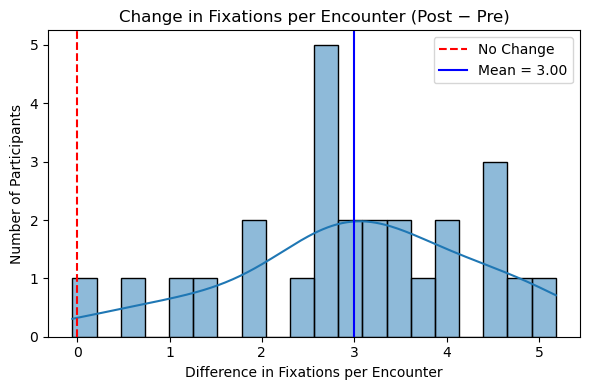

In [45]:

# Difference scores
df_pivot['Fixation_Diff'] = df_pivot['Post'] - df_pivot['Pre']

plt.figure(figsize=(6, 4))
sns.histplot(df_pivot['Fixation_Diff'], bins=20, kde=True)
plt.axvline(0, color='red', linestyle='--', label='No Change')
plt.axvline(df_pivot['Fixation_Diff'].mean(), color='blue', linestyle='-', label=f"Mean = {df_pivot['Fixation_Diff'].mean():.2f}")
plt.title("Change in Fixations per Encounter (Post âˆ’ Pre)")
plt.xlabel("Difference in Fixations per Encounter")
plt.ylabel("Number of Participants")
plt.legend()
plt.tight_layout()
plt.show()



In [46]:
n_fix_df.head()

SubjectID Pre_Post_Collapsed   NFix  NTrials  Fixations_per_Trial
0       365               Post  12916      134            96.388060
1       365                Pre  12538      134            93.567164
2       479               Post  19894      202            98.485149
3       479                Pre  18862      201            93.840796
4      1754               Post  16988      170            99.929412

In [47]:
n_fix_df.to_csv("/Volumes/TwoTeras/PCA/Data_Sets/Experiment_1/n_fix_df_window.csv", index=False)

In [48]:
# : Pivot to get Pre and Post as columns
df_diff = (
    n_fix_df.pivot(index='SubjectID', columns='Pre_Post_Collapsed', values='Fixations_per_Trial')
    .dropna(subset=['Pre', 'Post'])  # make sure both values are present
    .reset_index()
)

# : Calculate the difference
df_diff['Post_minus_Pre'] = df_diff['Post'] - df_diff['Pre']

# Final result
df_diff[['SubjectID', 'Post', 'Pre', 'Post_minus_Pre']]


Pre_Post_Collapsed SubjectID        Post         Pre  Post_minus_Pre
0                       1754   99.929412   95.382353        4.547059
1                       2258   94.680473   91.136095        3.544379
2                       2361   92.212435   88.523316        3.689119
3                       2693   93.242038   92.576923        0.665115
4                       3246   95.073620   92.300613        2.773006
5                       3310   99.935780   94.752294        5.183486
6                        365   96.388060   93.567164        2.820896
7                       3976   96.627119   94.050847        2.576271
8                       4176  102.916667  100.137500        2.779167
9                       4597   94.244898   93.163265        1.081633
10                       479   98.485149   93.840796        4.644352
11                      4796   99.236559   96.107527        3.129032
12                      4917   99.968421   97.389474        2.578947
13                      5741  105.064865  100.162162        4.902703
14                      6642   98.243243   94.243243        4.000000
15                      7093   90.297872   86.401070        3.896803
16                      7264  100.297030   97.024752        3.272277
17                      7412   92.156398   90.862559        1.293839
18                      7842   93.841270   89.222222        4.619048
19                      8007   96.559748   93.062893        3.496855
20                      8469   94.394958   92.428571        1.966387
21                      8673   93.509615   91.644231        1.865385
22                      9472  101.156863  101.209150       -0.052288
23                      9502   88.251029   85.691358        2.559671
24                      9586   85.365591   82.322581        3.043011
25                      9601   93.646154   90.641026        3.005128

In [49]:
# : Ensure datetime is available
filtered_trials_long_df['datetime'] = pd.to_datetime(filtered_trials_long_df['timeStampDataPointEnd'], unit='s')

Fixations_Windowed = filtered_trials_long_df[filtered_trials_long_df.events == 2] 
# : Group by subject/session/subsection + collapsed window
grouped = Fixations_Windowed.groupby(['SubjectID', 'Session', 'SessionSubsection', 'Pre_Post_Collapsed'])

# : Aggregate counts and times
fixation_rates = (
    grouped
    .agg(
        n_fixations=('datetime', 'count'),
        start_time=('datetime', 'min'),
        end_time=('datetime', 'max')
    )
    .reset_index()
)

# : Compute duration and rate
fixation_rates['duration_seconds'] = (fixation_rates['end_time'] - fixation_rates['start_time']).dt.total_seconds()
fixation_rates['fixations_per_second'] = fixation_rates['n_fixations'] / fixation_rates['duration_seconds']

# Final tidy output
fixation_rates = fixation_rates[['SubjectID', 'Session', 'SessionSubsection', 'Pre_Post_Collapsed', 'fixations_per_second']]


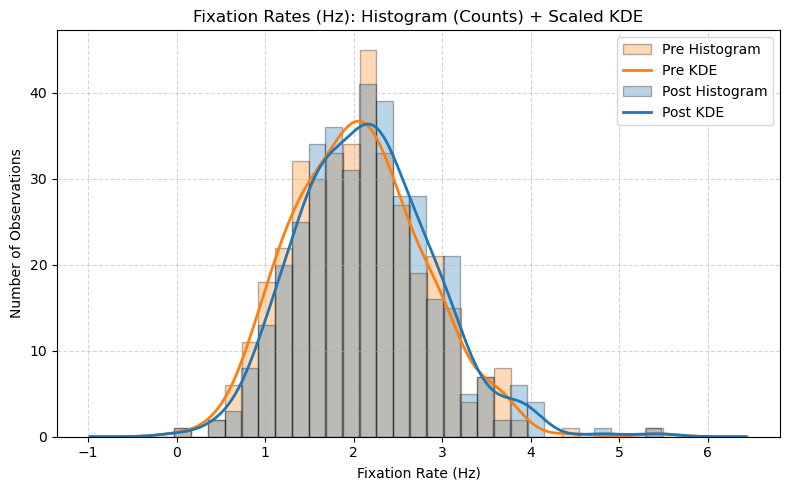

In [50]:
# Split the data
pre_data = fixation_rates[fixation_rates['Pre_Post_Collapsed'] == 'Pre']['fixations_per_second'].dropna()
post_data = fixation_rates[fixation_rates['Pre_Post_Collapsed'] == 'Post']['fixations_per_second'].dropna()

# Define group data and labels
group_data = {'Pre': pre_data, 'Post': post_data}
colors = {'Pre': 'tab:orange', 'Post': 'tab:blue'}

# Start plot
plt.figure(figsize=(8, 5))

# Loop through groups
for label, data in group_data.items():
    # Histogram (use raw counts)
    bin_edges = np.linspace(data.min() - 1, data.max() + 1, 40)
    counts, bins, _ = plt.hist(data, bins=bin_edges, density=False, alpha=0.3,
                                edgecolor='black', label=f'{label} Histogram', color=colors[label])

    # KDE
    kde = gaussian_kde(data)
    x_vals = np.linspace(data.min() - 1, data.max() + 1, 200)
    y_vals = kde(x_vals)

    # ðŸ”„ Scale KDE to match histogram's total count
    bin_width = bins[1] - bins[0]
    y_vals_scaled = y_vals * len(data) * bin_width

    # KDE line
    plt.plot(x_vals, y_vals_scaled, lw=2, label=f'{label} KDE', color=colors[label])

# Labels and formatting
plt.title('Fixation Rates (Hz): Histogram (Counts) + Scaled KDE')
plt.xlabel('Fixation Rate (Hz)')
plt.ylabel('Number of Observations')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


[Post] Area under KDE curve: 0.9971
[Pre] Area under KDE curve: 0.9970


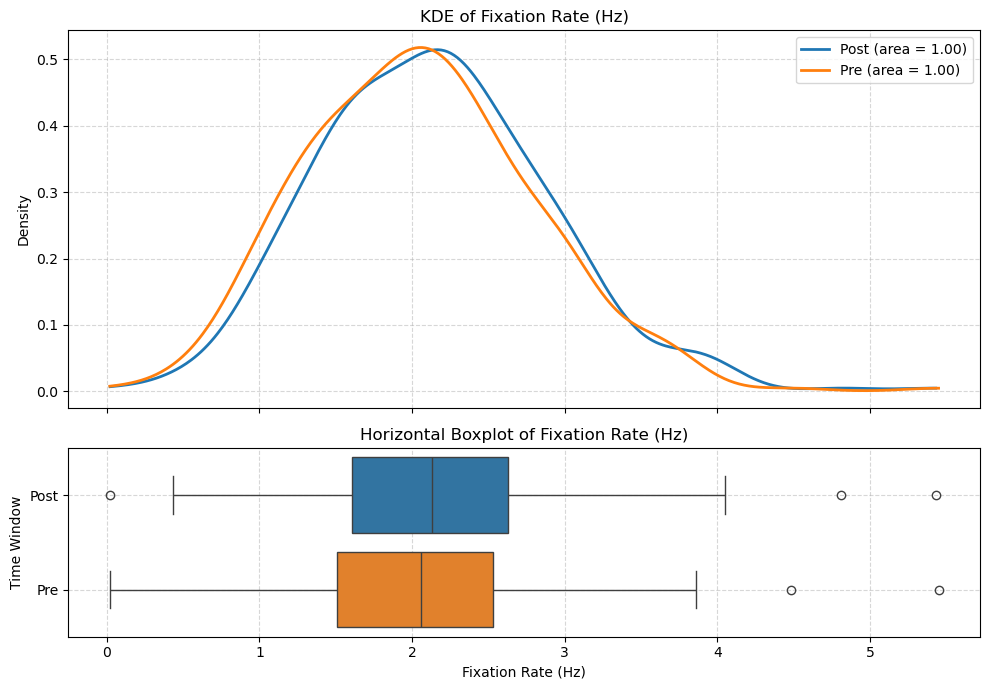

In [51]:
# --- : Clean and prepare data ---
df_clean = fixation_rates.dropna(subset=["fixations_per_second", "Pre_Post_Collapsed"])

# --- : Setup layout ---
fig, axes = plt.subplots(2, 1, figsize=(10, 7), gridspec_kw={'height_ratios': [2, 1]}, sharex=True)

# --- : Define color palette ---
group_colors = {'Pre': 'tab:orange', 'Post': 'tab:blue'}
unique_groups = sorted(df_clean['Pre_Post_Collapsed'].unique())

# --- : KDEs (tight range) ---
ax_kde = axes[0]

for group in unique_groups:
    subset = df_clean[df_clean['Pre_Post_Collapsed'] == group]['fixations_per_second'].dropna()
    if len(subset) < 2:
        continue  # Skip if not enough data

    kde = gaussian_kde(subset)
    x_vals = np.linspace(subset.min(), subset.max(), 500)
    y_vals = kde(x_vals)

    area = np.trapz(y_vals, x_vals)
    print(f"[{group}] Area under KDE curve: {area:.4f}")

    ax_kde.plot(x_vals, y_vals, lw=2, label=f"{group} (area = {area:.2f})", color=group_colors[group])

ax_kde.set_title("KDE of Fixation Rate (Hz)")
ax_kde.set_ylabel("Density")
ax_kde.legend()
ax_kde.grid(True, linestyle='--', alpha=0.5)

# --- : Horizontal boxplot ---
ax_box = axes[1]
sns.boxplot(
    data=df_clean,
    y="Pre_Post_Collapsed",
    x="fixations_per_second",
    orient="h",
    hue="Pre_Post_Collapsed",
    palette=group_colors,
    dodge=False,
    legend=False,
    ax=ax_box
)
ax_box.set_title("Horizontal Boxplot of Fixation Rate (Hz)")
ax_box.set_xlabel("Fixation Rate (Hz)")
ax_box.set_ylabel("Time Window")
ax_box.grid(True, linestyle='--', alpha=0.5)

# --- : Final layout ---
plt.tight_layout()
plt.show()


In [52]:
# : Compute the median and MAD for fixation durations
median_length = np.nanmedian(Fixations_Windowed.length)
mad = np.nanmedian(np.abs(Fixations_Windowed.length - median_length))
median_std = mad * 1.4826  # Approximates standard deviation under normality

# : Compute MAD-based z-scores
Fixations_Windowed['FixDur_mad_z'] = np.abs(Fixations_Windowed.length - median_length) / median_std

# : Flag outliers based on threshold
Fixations_Windowed['Outlier_FixDur'] = np.where(Fixations_Windowed['FixDur_mad_z'] > 3.5, 'Out', 'Stays')

# : Create filtered version excluding outliers
fixationEnd_no_out = Fixations_Windowed[Fixations_Windowed['Outlier_FixDur'] != 'Out'].copy()


/var/folders/wj/11sgsjxd7x75l9tkc6r2l1p80000gn/T/ipykernel_1142/2733411567.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Fixations_Windowed['FixDur_mad_z'] = np.abs(Fixations_Windowed.length - median_length) / median_std
/var/folders/wj/11sgsjxd7x75l9tkc6r2l1p80000gn/T/ipykernel_1142/2733411567.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Fixations_Windowed['Outlier_FixDur'] = np.where(Fixations_Windowed['FixDur_mad_z'] > 3.5, 'Out', 'Stays')


In [53]:
# : Sum total fixation duration per subject Ã— condition (already done)
# Sum fixation durations across all sessions per subject
total_fixation_dur = (
    fixationEnd_no_out.groupby(['SubjectID', 'Pre_Post_Collapsed'])['length']
    .median()
    .reset_index(name='median_duration_s')
)


# : Count number of unique trials per subject Ã— condition
trial_counts = (
    fixationEnd_no_out.groupby(['SubjectID', 'Pre_Post_Collapsed'])['Trial_ID']
    .nunique()
    .reset_index(name='NTrials')
)

# : Merge total duration with trial counts
total_fixation_dur = pd.merge(total_fixation_dur, trial_counts, on=['SubjectID', 'Pre_Post_Collapsed'])

# : Normalize duration per trial
total_fixation_dur['median_duration_per_encounter'] = total_fixation_dur['median_duration_s'] / total_fixation_dur['NTrials']


[Post] Area under KDE curve: 0.9586
[Pre] Area under KDE curve: 0.9582


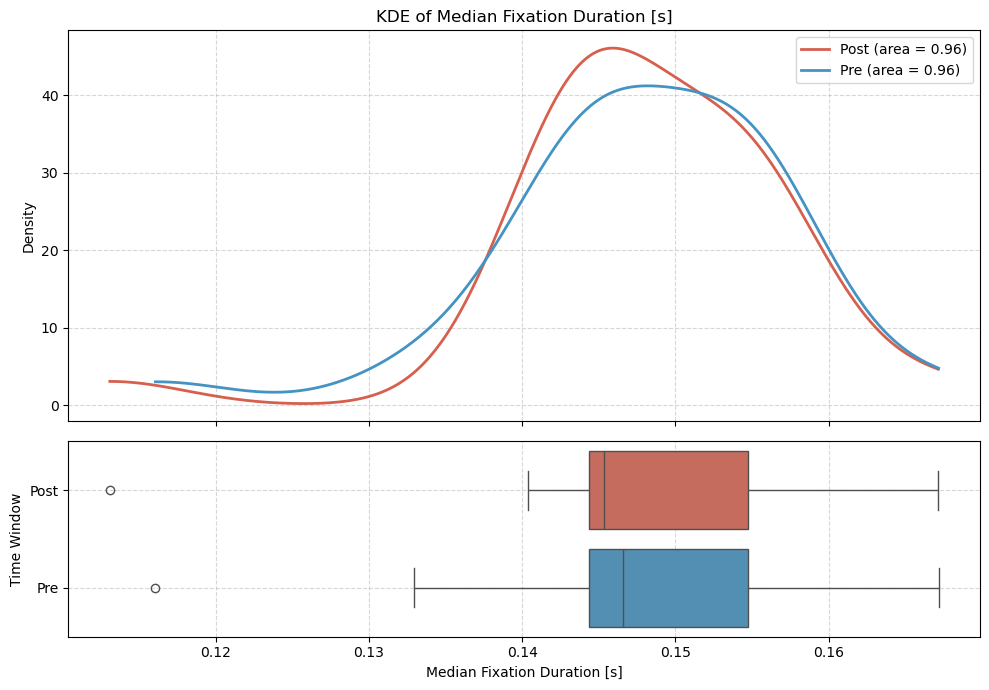

In [54]:
# --- : Clean and prepare data ---
df_clean = total_fixation_dur.dropna(subset=["median_duration_s", "Pre_Post_Collapsed"])

# --- : Setup layout ---
fig, axes = plt.subplots(2, 1, figsize=(10, 7), gridspec_kw={'height_ratios': [2, 1]}, sharex=True)

# --- : Define redâ€“blue palette ---
full_palette = sns.color_palette("RdBu", n_colors=4)
unique_groups = sorted(df_clean['Pre_Post_Collapsed'].unique())
group_colors = {
    unique_groups[0]: full_palette[0],   # Deep blue for 'Post'
    unique_groups[-1]: full_palette[-1]  # Deep red for 'Pre'
}

# --- : KDEs (tight range) ---
ax_kde = axes[0]

for group in unique_groups:
    subset = df_clean[df_clean['Pre_Post_Collapsed'] == group]['median_duration_s'].dropna()
    if len(subset) < 2:
        continue

    kde = gaussian_kde(subset)
    x_vals = np.linspace(subset.min(), subset.max(), 500)
    y_vals = kde(x_vals)

    area = np.trapz(y_vals, x_vals)
    print(f"[{group}] Area under KDE curve: {area:.4f}")

    ax_kde.plot(x_vals, y_vals, lw=2, label=f"{group} (area = {area:.2f})", color=group_colors[group])

ax_kde.set_title("KDE of Median Fixation Duration [s]")
ax_kde.set_ylabel("Density")
ax_kde.legend()
ax_kde.grid(True, linestyle='--', alpha=0.5)

# --- : Horizontal boxplot ---
ax_box = axes[1]
sns.boxplot(
    data=df_clean,
    y="Pre_Post_Collapsed",
    x="median_duration_s",
    orient="h",
    hue="Pre_Post_Collapsed",
    palette=group_colors,
    dodge=False,
    ax=ax_box
)

ax_box.set_xlabel("Median Fixation Duration [s]")
ax_box.set_ylabel("Time Window")
ax_box.grid(True, linestyle='--', alpha=0.5)

# --- : Final layout ---
plt.tight_layout()
plt.show()


In [55]:
#  Pivot to get Pre and Post Fixations_per_Trial per subject
df_pivot = df_clean.pivot(index='SubjectID', columns='Pre_Post_Collapsed', values='median_duration_s').dropna()

# Run Wilcoxon test
stat, p = wilcoxon(df_pivot['Post'], df_pivot['Pre'])

display(stat, p)

# Compute Z from W using normal approximation (with continuity correction)
n = len(df_pivot)
mean_W = n * (n + 1) / 4
std_W = np.sqrt(n * (n + 1) * (2 * n + 1) / 24)
z = (stat - mean_W) / std_W

# Effect size Rank-biserial correlation (often simply written as r)
r = abs(z) / np.sqrt(n)
print(f"Wilcoxon effect size r = {r:.3f}")



158.5

0.9142717422717499

Wilcoxon effect size r = 0.085


In [56]:
df_pivot['diff'] = df_pivot['Post'] - df_pivot['Pre']
print(df_pivot['diff'].describe())


count    2.600000e+01
mean     1.227489e-04
std      3.424212e-03
min     -9.174109e-03
25%     -4.960895e-04
50%     -1.192093e-07
75%      8.676052e-04
max      1.088881e-02
Name: diff, dtype: float64


In [57]:
# Step: Cumulative fixation duration per trial window
fixation_per_trial = (
    fixationEnd_no_out.groupby(['SubjectID', 'Pre_Post_Collapsed'])['length']
    .sum()
    .reset_index(name='cumulative_fixation_duration_s')
)

# : Count number of unique trials per subject Ã— condition
trial_counts = (
    fixationEnd_no_out.groupby(['SubjectID', 'Pre_Post_Collapsed'])['Trial_ID']
    .nunique()
    .reset_index(name='NTrials')
)

# : Merge total duration with trial counts
total_fixation_dur = pd.merge(fixation_per_trial, trial_counts, on=['SubjectID', 'Pre_Post_Collapsed'])

# : Normalize duration per trial
total_fixation_dur['median_Cumm_duration_per_encounter'] = total_fixation_dur['cumulative_fixation_duration_s'] / total_fixation_dur['NTrials']

total_fixation_dur.median_Cumm_duration_per_encounter.describe()


count    52.000000
mean     15.989282
std       0.918438
min      12.974343
25%      15.656556
50%      16.202645
75%      16.602142
max      17.588398
Name: median_Cumm_duration_per_encounter, dtype: float64

[Post] Area under KDE curve: 0.9233
[Pre] Area under KDE curve: 0.8950


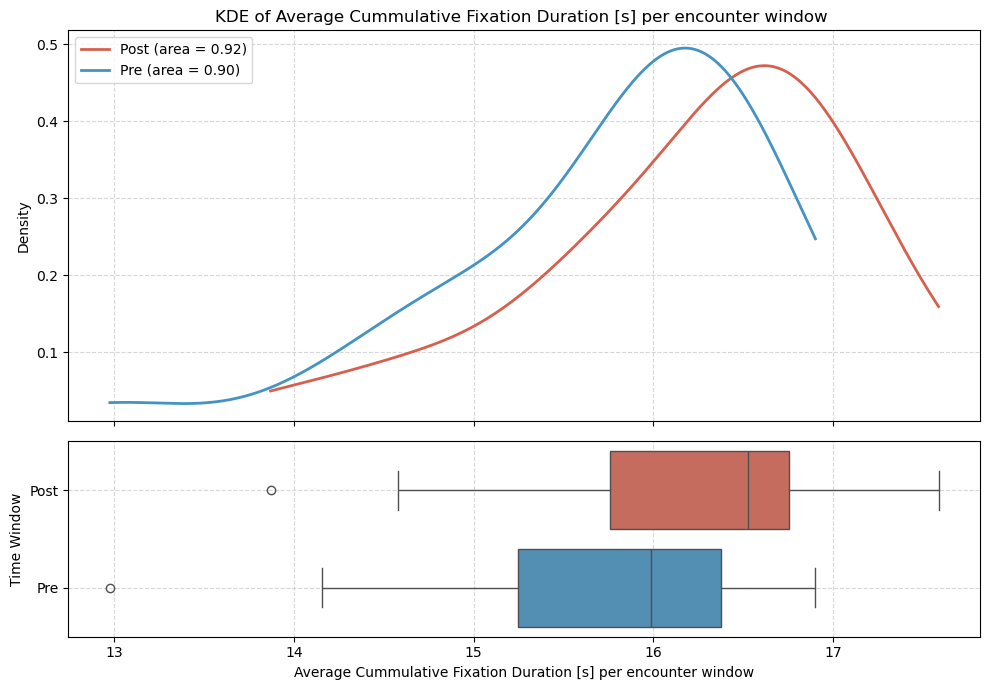

In [58]:
# --- Step 1: Clean and prepare data ---
df_clean = total_fixation_dur.dropna(subset=["median_Cumm_duration_per_encounter", "Pre_Post_Collapsed"])

# --- : Setup layout ---
fig, axes = plt.subplots(2, 1, figsize=(10, 7), gridspec_kw={'height_ratios': [2, 1]}, sharex=True)

# --- : Define redâ€“blue palette ---
full_palette = sns.color_palette("RdBu", n_colors=4)
unique_groups = sorted(df_clean['Pre_Post_Collapsed'].unique())
group_colors = {
    unique_groups[0]: full_palette[0],   # Deep blue for 'Post'
    unique_groups[-1]: full_palette[-1]  # Deep red for 'Pre'
}

# --- : KDEs (tight range) ---
ax_kde = axes[0]

for group in unique_groups:
    subset = df_clean[df_clean['Pre_Post_Collapsed'] == group]['median_Cumm_duration_per_encounter'].dropna()
    if len(subset) < 2:
        continue

    kde = gaussian_kde(subset)
    x_vals = np.linspace(subset.min(), subset.max(), 500)
    y_vals = kde(x_vals)

    area = np.trapz(y_vals, x_vals)
    print(f"[{group}] Area under KDE curve: {area:.4f}")

    ax_kde.plot(x_vals, y_vals, lw=2, label=f"{group} (area = {area:.2f})", color=group_colors[group])

ax_kde.set_title("KDE of Average Cummulative Fixation Duration [s] per encounter window ")
ax_kde.set_ylabel("Density")
ax_kde.legend()
ax_kde.grid(True, linestyle='--', alpha=0.5)

# --- : Horizontal boxplot ---
ax_box = axes[1]
sns.boxplot(
    data=df_clean,
    y="Pre_Post_Collapsed",
    x="median_Cumm_duration_per_encounter",
    orient="h",
    hue="Pre_Post_Collapsed",
    palette=group_colors,
    dodge=False,
    ax=ax_box
)

ax_box.set_xlabel("Average Cummulative Fixation Duration [s] per encounter window")
ax_box.set_ylabel("Time Window")
ax_box.grid(True, linestyle='--', alpha=0.5)

# --- : Final layout ---
plt.tight_layout()
plt.show()


In [59]:
# 1. Pivot to get Pre and Post Fixations_per_Trial per subject
df_pivot = df_clean.pivot(index='SubjectID', columns='Pre_Post_Collapsed', values='median_Cumm_duration_per_encounter').dropna()

# Run Wilcoxon test
stat, p = wilcoxon(df_pivot['Post'], df_pivot['Pre'])


stat, p 

(0.0, 2.9802322387695312e-08)

In [60]:
# Compute Z from W using normal approximation (with continuity correction)
n = len(df_pivot)
mean_W = n * (n + 1) / 4
std_W = np.sqrt(n * (n + 1) * (2 * n + 1) / 24)
z = (stat - mean_W) / std_W

# Effect size Rank-biserial correlation (often simply written as r)
r = abs(z) / np.sqrt(n)
print(f"Wilcoxon effect size r = {r:.3f}")


Wilcoxon effect size r = 0.874


In [61]:
# Step 1: Compute fixation duration statistics
df_FixDur = (
    fixationEnd_no_out
    .groupby(['SubjectID', 'Pre_Post_Collapsed' ])['length']
    .agg([
        ('FixationDuration_25%', lambda x: np.nanquantile(x, 0.25)),
        ('FixationDuration_med', lambda x: np.nanmedian(x)),
        ('FixationDuration_75%', lambda x: np.nanquantile(x, 0.75)),
        ('FixationDuration_mean', lambda x: np.nanmean(x)),
        ('FixationDuration_sd', lambda x: np.nanstd(x)),
        ('FixationDuration_min', lambda x: np.nanmin(x)),
        ('FixationDuration_max', lambda x: np.nanmax(x))
    ])
    .reset_index()
)

# : Compute spread and skew
df_FixDur['FixationDuration_DistQ1-Q3'] = (
    df_FixDur['FixationDuration_75%'] - df_FixDur['FixationDuration_25%']
)

df_FixDur['FixationDuration_bowleyCoef'] = (
    (df_FixDur['FixationDuration_75%'] + df_FixDur['FixationDuration_25%']
     - 2 * df_FixDur['FixationDuration_med']) 
    / df_FixDur['FixationDuration_DistQ1-Q3']
)

# : Drop unused quantiles if desired
df_FixDur = df_FixDur.drop(columns=['FixationDuration_25%', 'FixationDuration_75%'])

# Final output
df_FixDur.head()

SubjectID Pre_Post_Collapsed  FixationDuration_med  FixationDuration_mean  \
0        365               Post              0.155247               0.185104   
1        365                Pre              0.154752               0.183967   
2        479               Post              0.143841               0.174429   
3        479                Pre              0.153015               0.180579   
4       1754               Post              0.155744               0.181823   

   FixationDuration_sd  FixationDuration_min  FixationDuration_max  \
0             0.122953              0.015872              0.566929   
1             0.122662              0.008928              0.566929   
2             0.117644              0.014385              0.566928   
3             0.119302              0.011407              0.566928   
4             0.117611              0.011407              0.566932   

   FixationDuration_DistQ1-Q3  FixationDuration_bowleyCoef  
0                    0.167152                     0.192883  
1                    0.174573                     0.153529  
2                    0.152272                     0.172636  
3                    0.152273                     0.149856  
4                    0.152770                     0.123370

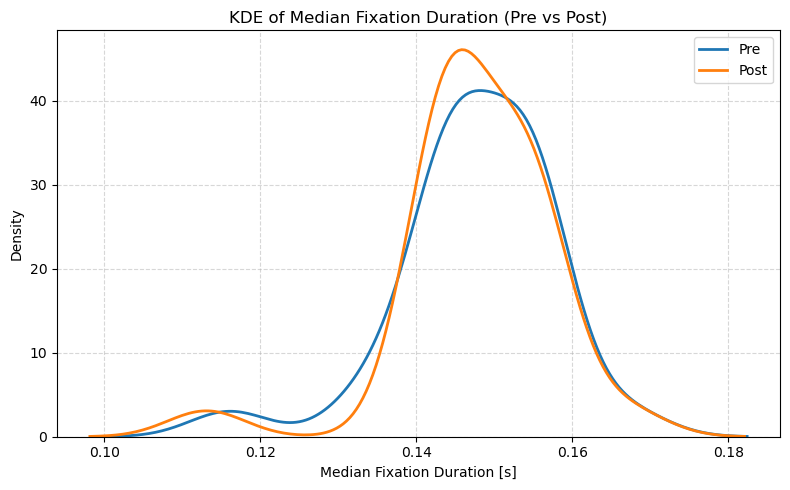

In [62]:
# Split the data
pre_data = df_FixDur[df_FixDur['Pre_Post_Collapsed'] == 'Pre']['FixationDuration_med'].dropna()
post_data = df_FixDur[df_FixDur['Pre_Post_Collapsed'] == 'Post']['FixationDuration_med'].dropna()
# Plot KDEs
plt.figure(figsize=(8, 5))
sns.kdeplot(pre_data, label='Pre', linewidth=2)
sns.kdeplot(post_data, label='Post', linewidth=2)
plt.title('KDE of Median Fixation Duration (Pre vs Post)')
plt.xlabel('Median Fixation Duration [s]')
plt.ylabel('Density')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


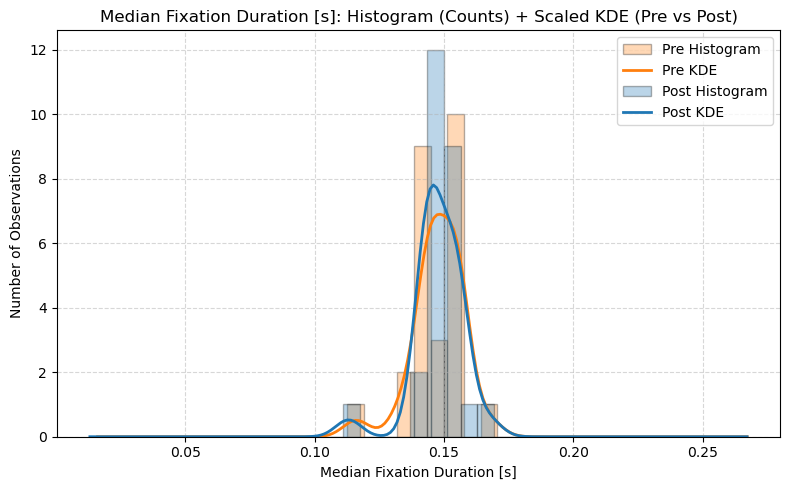

In [63]:
# Prepare data
pre_data = df_FixDur[df_FixDur['Pre_Post_Collapsed'] == 'Pre']['FixationDuration_med'].dropna()
post_data = df_FixDur[df_FixDur['Pre_Post_Collapsed'] == 'Post']['FixationDuration_med'].dropna()

group_data = {'Pre': pre_data, 'Post': post_data}
colors = {'Pre': 'tab:orange', 'Post': 'tab:blue'}

plt.figure(figsize=(8, 5))

for label, data in group_data.items():
    # Histogram (counts)
    bin_edges = np.linspace(data.min() - 0.1, data.max() + 0.1, 40)
    counts, bins, _ = plt.hist(
        data, bins=bin_edges, density=False, alpha=0.3,
        edgecolor='black', label=f'{label} Histogram',
        color=colors[label]
    )

    # KDE
    kde = gaussian_kde(data)
    x_vals = np.linspace(data.min() - 0.1, data.max() + 0.1, 200)
    y_vals = kde(x_vals)

    # Scale KDE to match histogram (area = count)
    bin_width = bins[1] - bins[0]
    y_vals_scaled = y_vals * len(data) * bin_width

    # Plot KDE line
    plt.plot(x_vals, y_vals_scaled, lw=2, label=f'{label} KDE', color=colors[label])

# Final formatting
plt.title('Median Fixation Duration [s]: Histogram (Counts) + Scaled KDE (Pre vs Post)')
plt.xlabel('Median Fixation Duration [s]')
plt.ylabel('Number of Observations')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [64]:
# Group and aggregate avg_dist for fixationEnd
df_dist = (
    fixationEnd_no_out
    .groupby(['SubjectID', 'Pre_Post_Collapsed' ])
    .agg(
        FixationDist_25pct=('avg_dist', lambda x: np.nanquantile(x, 0.25)),
        FixationDist_med=('avg_dist', np.nanmedian),
        FixationDist_75pct=('avg_dist', lambda x: np.nanquantile(x, 0.75))
    )
    .reset_index()
)
df_dist

/var/folders/wj/11sgsjxd7x75l9tkc6r2l1p80000gn/T/ipykernel_1142/1289500176.py:5: FutureWarning: The provided callable <function nanmedian at 0x11288ec00> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  .agg(


SubjectID Pre_Post_Collapsed  FixationDist_25pct  FixationDist_med  \
0         365               Post           25.169595         42.924518   
1         365                Pre           26.918938         44.925965   
2         479               Post           15.654582         34.018520   
3         479                Pre           22.584330         42.872239   
4        1754               Post           13.979653         25.217397   
5        1754                Pre           15.630825         28.302904   
6        2258               Post           16.350612         32.575842   
7        2258                Pre           19.258220         35.972541   
8        2361               Post           13.303272         26.448626   
9        2361                Pre           17.789928         33.627093   
10       2693               Post           16.700519         34.555055   
11       2693                Pre           22.683374         43.636958   
12       3246               Post           19.431716         35.349828   
13       3246                Pre           21.334853         37.924266   
14       3310               Post           22.042356         39.580970   
15       3310                Pre           23.256297         41.565786   
16       3976               Post           20.991187         35.763063   
17       3976                Pre           22.198565         38.138807   
18       4176               Post           15.955822         30.057647   
19       4176                Pre           17.600633         32.761048   
20       4597               Post           15.314833         29.773324   
21       4597                Pre           18.919734         35.917256   
22       4796               Post           19.201403         35.142333   
23       4796                Pre           20.033555         36.999995   
24       4917               Post           19.000111         33.581314   
25       4917                Pre           19.669636         35.443745   
26       5741               Post           16.505125         29.164930   
27       5741                Pre           19.629116         37.790604   
28       6642               Post           13.833779         27.345121   
29       6642                Pre           14.588772         29.464803   
30       7093               Post           10.273208         20.256382   
31       7093                Pre           11.652429         23.556163   
32       7264               Post           17.568549         32.304783   
33       7264                Pre           20.057094         35.038451   
34       7412               Post           17.000970         31.340587   
35       7412                Pre           20.449339         36.772520   
36       7842               Post           18.977279         31.714960   
37       7842                Pre           20.543954         34.440060   
38       8007               Post           15.706725         29.826975   
39       8007                Pre           17.573404         31.867959   
40       8469               Post           21.198118         36.870271   
41       8469                Pre           22.841632         41.612102   
42       8673               Post           13.018140         25.907092   
43       8673                Pre           16.499179         31.700442   
44       9472               Post            9.867972         19.822998   
45       9472                Pre           11.919464         24.554756   
46       9502               Post           14.162534         27.357865   
47       9502                Pre           16.408419         31.427338   
48       9586               Post           16.805273         30.286396   
49       9586                Pre           19.213213         35.853566   
50       9601               Post           19.570474         34.745818   
51       9601                Pre           21.597083         38.204612   

    FixationDist_75pct  
0            74.274476  
1            76.776877  
2     

In [65]:
# : Compute spread and skew
df_dist['FixationDist_DurQ1-Q3'] = (
    df_dist['FixationDist_75pct'] - df_dist['FixationDist_25pct']
)

df_dist['FixationDist_bowleyCoef'] = (
    (df_dist['FixationDist_75pct'] + df_dist['FixationDist_25pct']
     - 2 * df_dist['FixationDist_med']) 
    / df_dist['FixationDist_DurQ1-Q3']
)

# : Drop unused quantiles
df_dist = df_dist.drop(columns=['FixationDist_25pct', 'FixationDist_75pct'])

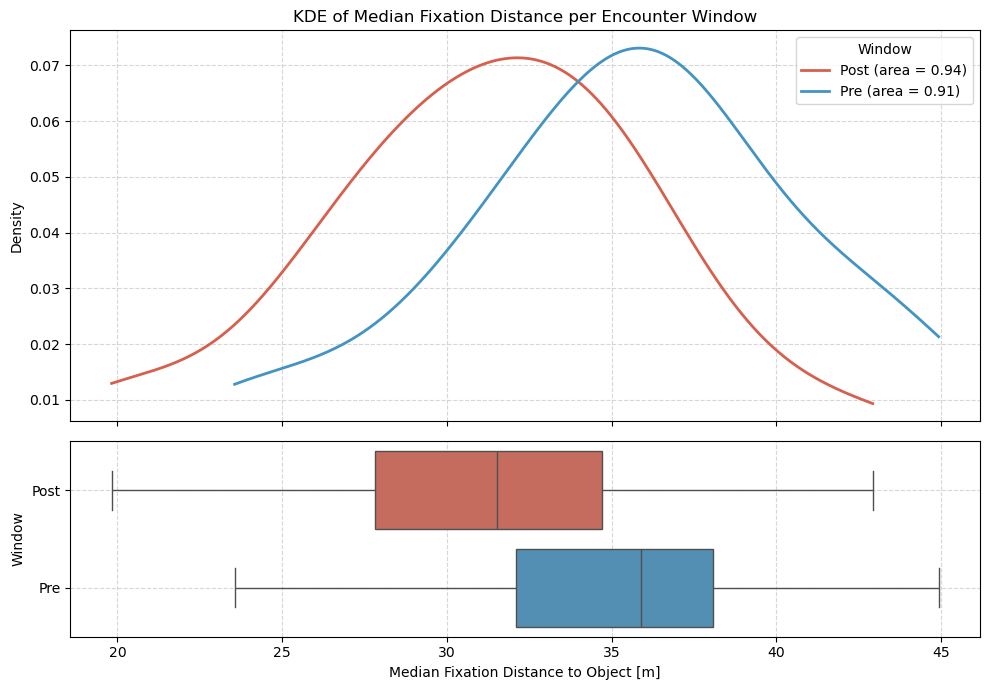

In [66]:
# : Clean and prepare data
df_clean = df_dist.dropna(subset=["FixationDist_med", "Pre_Post_Collapsed"])

# : Setup layout
fig, axes = plt.subplots(2, 1, figsize=(10, 7), gridspec_kw={'height_ratios': [2, 1]}, sharex=True)

# : Define redâ€“blue palette
full_palette = sns.color_palette("RdBu", n_colors=4)
unique_groups = sorted(df_clean['Pre_Post_Collapsed'].unique())
group_colors = {
    unique_groups[0]: full_palette[0],   # Deep blue for 'Post'
    unique_groups[-1]: full_palette[-1]  # Deep red for 'Pre'
}

# : KDEs (tight range)
ax_kde = axes[0]
for group in unique_groups:
    subset = df_clean[df_clean['Pre_Post_Collapsed'] == group]['FixationDist_med'].dropna()
    if len(subset) < 2:
        continue

    kde = gaussian_kde(subset)
    x_vals = np.linspace(subset.min(), subset.max(), 500)
    y_vals = kde(x_vals)

    area = np.trapz(y_vals, x_vals)
    ax_kde.plot(x_vals, y_vals, lw=2, label=f"{group} (area = {area:.2f})", color=group_colors[group])

ax_kde.set_title("KDE of Median Fixation Distance per Encounter Window")
ax_kde.set_ylabel("Density")
ax_kde.legend(title="Window")
ax_kde.grid(True, linestyle='--', alpha=0.5)

# : Horizontal boxplot
ax_box = axes[1]
sns.boxplot(
    data=df_clean,
    y="Pre_Post_Collapsed",
    x="FixationDist_med",
    orient="h",
    hue="Pre_Post_Collapsed",
    palette=group_colors,
    dodge=False,
    ax=ax_box
)

ax_box.set_xlabel("Median Fixation Distance to Object [m]")
ax_box.set_ylabel("Window")
ax_box.grid(True, linestyle='--', alpha=0.5)


# : Final layout
plt.tight_layout()
plt.show()


In [67]:
#  Pivot to get Pre and Post Fixations_per_Trial per subject
df_pivot = df_clean.pivot(index='SubjectID', columns='Pre_Post_Collapsed', values='FixationDist_med').dropna()

# Run Wilcoxon test
stat, p = wilcoxon(df_pivot['Post'], df_pivot['Pre'])

display(stat, p)

# Compute Z from W using normal approximation (with continuity correction)
n = len(df_pivot)
mean_W = n * (n + 1) / 4
std_W = np.sqrt(n * (n + 1) * (2 * n + 1) / 24)
z = (stat - mean_W) / std_W

# Effect size Rank-biserial correlation (often simply written as r)
r = abs(z) / np.sqrt(n)
print(f"Wilcoxon effect size r = {r:.3f}")


0.0

2.9802322387695312e-08

Wilcoxon effect size r = 0.874


In [68]:
n_fix_df.to_csv("/Volumes/TwoTeras/PCA/Data_Sets/Experiment_1/NFixations_window.csv", index=False)
df_FixDur.to_csv("/Volumes/TwoTeras/PCA/Data_Sets/Experiment_1/FixationDuration_window.csv", index=False)
df_dist.to_csv("/Volumes/TwoTeras/PCA/Data_Sets/Experiment_1/DistanceToFixation_window.csv", index=False)

In [69]:
# Define helper functions
def compute_centroid(df, columns):
    return df[columns].mean().values

def compute_saccade_amplitude(prev_gaze_centroid, prev_subject_centroid, gaze_centroid, subject_centroid):
    v_eye_vec = gaze_centroid - prev_gaze_centroid 
    eye_vec = prev_gaze_centroid - prev_subject_centroid
    eye_vec = eye_vec / np.linalg.norm(eye_vec)
    projection = np.dot(v_eye_vec, eye_vec) * eye_vec
    v_eye_inplane = np.linalg.norm(v_eye_vec - projection)
    sacc_amplitude = np.arctan2(v_eye_inplane, np.linalg.norm(prev_subject_centroid - prev_gaze_centroid))
    return np.degrees(sacc_amplitude)

def compute_saccades_within_trial(df):
    results = []

    for trial_id, trial_df in tqdm(df.groupby('Trial_ID'), desc="Processing Trials"):
        trial_df = trial_df.copy()
        trial_df = trial_df.sort_values('timeStampDataPointEnd')

        fixation_starts = trial_df[trial_df['events'] == 2.0].index
        fixation_ends = trial_df[trial_df['events'] == -2.0].index
        saccade_starts = trial_df[trial_df['events'] == 1.0].index
        saccade_ends = trial_df[trial_df['events'] == -1.0].index

        if len(fixation_starts) == 0 or len(fixation_ends) == 0 or len(saccade_starts) == 0 or len(saccade_ends) == 0:
            continue

        if fixation_ends[0] < fixation_starts[0]:
            fixation_ends = fixation_ends[1:]
        if len(fixation_starts) > len(fixation_ends):
            fixation_starts = fixation_starts[:len(fixation_ends)]

        fixations = list(zip(fixation_starts, fixation_ends))
        if len(fixations) < 2:
            continue

        for i in range(1, len(fixations)):
            prev_start, prev_end = fixations[i - 1]
            curr_start, curr_end = fixations[i]

            prev_fix = trial_df.loc[prev_start:prev_end]
            curr_fix = trial_df.loc[curr_start:curr_end]

            prev_gaze_centroid = compute_centroid(prev_fix, ['hitPointOnObject_x', 'hitPointOnObject_y', 'hitPointOnObject_z'])
            prev_subject_centroid = compute_centroid(prev_fix, ['eyePositionCombinedWorld.x', 'eyePositionCombinedWorld.y', 'eyePositionCombinedWorld.z'])

            curr_gaze_centroid = compute_centroid(curr_fix, ['hitPointOnObject_x', 'hitPointOnObject_y', 'hitPointOnObject_z'])
            curr_subject_centroid = compute_centroid(curr_fix, ['eyePositionCombinedWorld.x', 'eyePositionCombinedWorld.y', 'eyePositionCombinedWorld.z'])

            amp = compute_saccade_amplitude(prev_gaze_centroid, prev_subject_centroid, curr_gaze_centroid, curr_subject_centroid)

            saccade = trial_df[
                (trial_df.index > prev_end) & 
                (trial_df.index < curr_start) & 
                (trial_df['events'] == 1.0)
            ]
            if saccade.empty:
                continue

            saccade_idx = saccade.index[0]
            sacc_segment = trial_df.loc[saccade_idx:curr_start]
            try:
                peak_velocity = np.nanmax(sacc_segment['combined_vel'].values)
            except:
                peak_velocity = np.nan

            row = {
                'Trial_ID': trial_id,
                'SubjectID': trial_df['SubjectID'].iloc[0],
                'Session': trial_df['Session'].iloc[0],
                'SessionSubsection': trial_df['SessionSubsection'].iloc[0],
                'Pre_Post_Collapsed': trial_df['Pre_Post_Collapsed'].iloc[0],
                'saccade_amplitude': amp,
                'peak_velocity': peak_velocity
            }
            results.append(row)

    return pd.DataFrame(results)


In [70]:
saccade_summary = compute_saccades_within_trial(filtered_trials_long_df)


Processing Trials: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 4364/4364 [08:20<00:00,  8.72it/s]


In [71]:
filtered_trials_long_df.Pre_Post_Collapsed.value_counts()

Pre_Post_Collapsed
Post    8266459
Pre     8035923
Name: count, dtype: int64

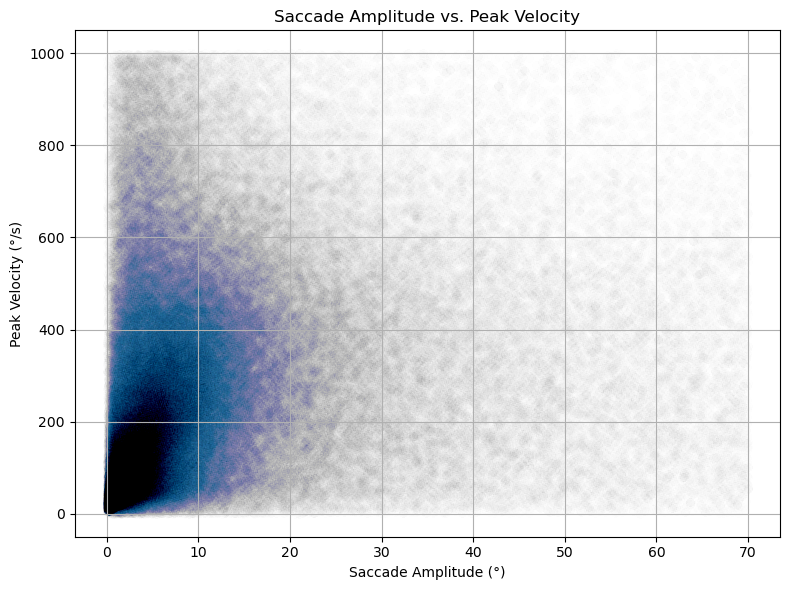

In [72]:
saccade_results_filtered = saccade_summary[(saccade_summary.peak_velocity < 1000) & (saccade_summary.saccade_amplitude < 70)]
# Filter valid rows
df_plot = saccade_results_filtered.dropna(subset=['saccade_amplitude', 'peak_velocity'])



# Create scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_plot,
    x='saccade_amplitude',
    y='peak_velocity',
    alpha=0.002,
    edgecolor='black'
)

# Labels and formatting
plt.xlabel('Saccade Amplitude (Â°)')
plt.ylabel('Peak Velocity (Â°/s)')
plt.title('Saccade Amplitude vs. Peak Velocity')
plt.grid(True)
plt.tight_layout()
plt.show()

In [73]:
# Step 1: Drop NaNs and compute median amplitude per window
df_saccades_clean = saccade_results_filtered.dropna(subset=["saccade_amplitude", "Pre_Post_Collapsed"])

# Step 2: Compute median amplitude per Trial_ID Ã— Window
df_amp_med = (
    df_saccades_clean
    .groupby(["Trial_ID", "Pre_Post_Collapsed"])["saccade_amplitude"]
    .median()
    .reset_index(name="SaccadeAmplitude_med")
)
df_amp_med.Pre_Post_Collapsed.value_counts()

Pre_Post_Collapsed
Pre    4364
Name: count, dtype: int64

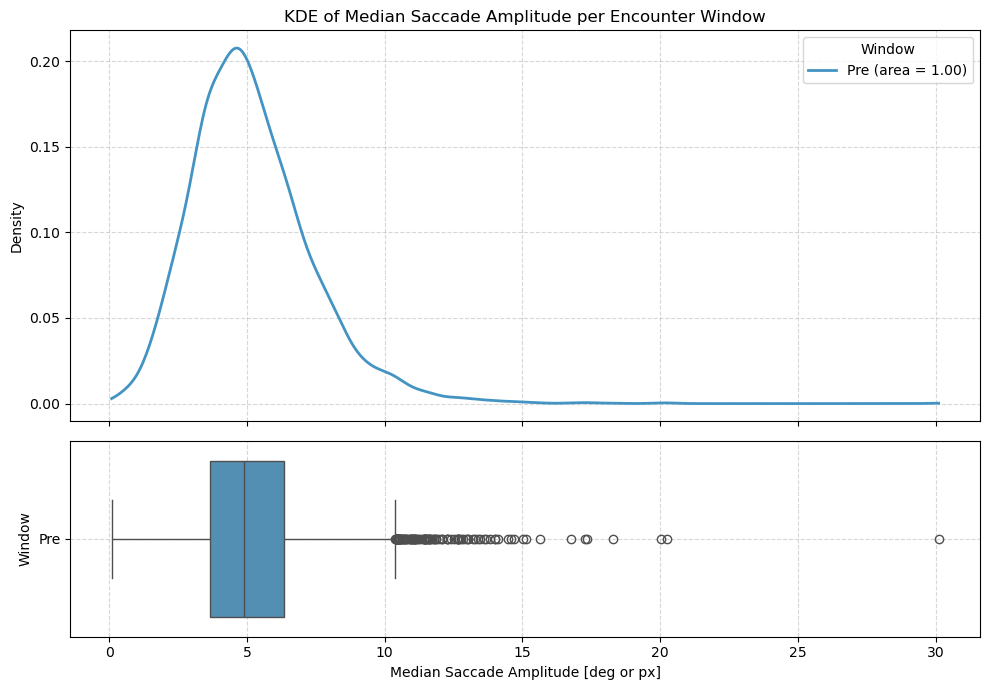

In [74]:


# Setup layout
fig, axes = plt.subplots(2, 1, figsize=(10, 7), gridspec_kw={'height_ratios': [2, 1]}, sharex=True)

# Define redâ€“blue palette
full_palette = sns.color_palette("RdBu", n_colors=4)
unique_groups = sorted(df_amp_med['Pre_Post_Collapsed'].unique())
group_colors = {
    unique_groups[0]: full_palette[0],   # Deep blue for 'Post'
    unique_groups[-1]: full_palette[-1]  # Deep red for 'Pre'
}

# KDE plot
ax_kde = axes[0]
for group in unique_groups:
    subset = df_amp_med[df_amp_med['Pre_Post_Collapsed'] == group]["SaccadeAmplitude_med"].dropna()
    if len(subset) < 2:
        continue

    kde = gaussian_kde(subset)
    x_vals = np.linspace(subset.min(), subset.max(), 500)
    y_vals = kde(x_vals)
    area = np.trapz(y_vals, x_vals)

    ax_kde.plot(x_vals, y_vals, lw=2, label=f"{group} (area = {area:.2f})", color=group_colors[group])

ax_kde.set_title("KDE of Median Saccade Amplitude per Encounter Window")
ax_kde.set_ylabel("Density")
ax_kde.legend(title="Window")
ax_kde.grid(True, linestyle='--', alpha=0.5)

# Boxplot
ax_box = axes[1]
sns.boxplot(
    data=df_amp_med,
    y="Pre_Post_Collapsed",
    x="SaccadeAmplitude_med",
    orient="h",
    hue="Pre_Post_Collapsed",
    palette=group_colors,
    dodge=False,
    ax=ax_box
)

ax_box.set_xlabel("Median Saccade Amplitude [deg or px]")
ax_box.set_ylabel("Window")
ax_box.grid(True, linestyle='--', alpha=0.5)

# Final layout
plt.tight_layout()
plt.show()
